# Application of a PiNN on the Mackey Glass time series
# (when only the initial condition and parameters are specified)

# Combined Bachelor Thesis (NS-320B), June 2022
## Mathematics & Physics and Astronomy
*'Applying Physics-informed Neural Networks to Chaotic Systems of Ordinary Differential Equations'*

**Author:** Martijn Sebastiaan Brouwer (6859488)

**Mathematics supervisors:** prof. dr. ir. C.W. Oosterlee

**Physics supervisor:** dr. J. de Graaf

**PhD supervisor:** B. Negyesi

## Making directories and importing packages

In [1]:
!mkdir plots_x

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


## Definitions 
### (Fully Connected Network (FCN), Runge-Kutta fourth order method, plotting and saving animated gifs)

In [2]:
# ----------------------------------------------------------------------------- 
# -------------------------- Fully Connected Network --------------------------
# ----------------------------------------------------------------------------- 
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going through the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# ----------------------------------------------------------------------------- 
# ----------- Runge-Kutta fourth order method (adapted for MG) ---------------- 
# ----------------------------------------------------------------------------- 
def RungeKutta(dxdt, x0, tf, n): # Specify derivatives, initial conditions and time
    h = tf/n   #Stepsize
    xl = n*[0] #Create lists for output
    xl[0] = x0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x_t = xl[i-1]
        if i-1 >= n/tf*tau:
            x_t_minus_tau = xl[int(i-1-n/tf*tau)]
        else: 
            x_t_minus_tau = 0

        #Going through the four RK4 equations:
        k1x = h*dxdt(x_t, x_t_minus_tau)
        xs  = x_t + 0.5*k1x
        xs_minus_tau = x_t_minus_tau + 0.5*k1x
        k2x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + 0.5*k2x  
        xs_minus_tau = x_t_minus_tau + 0.5*k2x
        k3x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + k3x
        xs_minus_tau = x_t_minus_tau + k3x
        k4x = h*dxdt(xs, xs_minus_tau)
        #Update last next value in output list:
        xl[i] = x_t + (k1x + 2*k2x + 2*k3x + k4x)/6 
    return xl


# ----------------------------------------------------------------------------- 
# -------------- 2D plot of RK4 approximation and PINN prediction ------------- 
# ----------------------------------------------------------------------------- 
def plot2D(T,X1,tf, t,pred, init, axis):
    plt.figure()
    plt.plot(T[:int((tf+3)*100)], X1[:int((tf+3)*100)], color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t, pred, color="tab:blue", linewidth=2, alpha=0.6, label="PiNN prediction")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss1: {:.2e}".format(loss1),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss2: {:.2e}".format(loss2),xy=(1.05, 0.67),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.1f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1f}".format(tf, alpha, update_t),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# ----------------------------------------------------------------------------- 
# -------------------------- Creating GIF animations -------------------------- 
# ----------------------------------------------------------------------------- 
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


## Parameters of the Mackey Glass time series and the PiNN

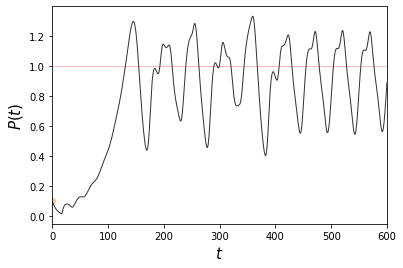

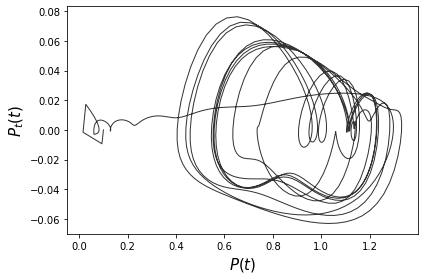

In [17]:
# ----------------------------------------------------------------------------- 
# ----------------- Mackey Glass time series parameters ----------------------- 
# ----------------------------------------------------------------------------- 
x0 = 0.1              #Initial conditions
a,b,tau = 0.2,0.1,17   #Parameters of the system
ti = 0               #Initial time
tf = 10              #Starting final time (without update)
n = 1000             #Steps taken between ti and tf
h = tf/n             #Step size of each step of n

# ----------------------------------------------------------------------------- 
# ------------------------------ PiNN parameters ------------------------------ 
# ----------------------------------------------------------------------------- 
lr = 1e-4            #Learning rate
INPUT = 1            #Amount of inputs
N_HIDDEN = 50        #Amount of hidden layers
N_LAYERS = 4         #Amount of neurons in hidden layers
OUTPUT = 1           #Amount of outputs
alpha = 0.000001    #Threshold value for updating tf with update_t
update_t = 5         #Update value for tf after reaching threshold
intermediate = 2500  #Safe intermediate results after every {intermediate} iterations

# ----------------------------------------------------------------------------- 
# ------------------- Mackey Glass differential equation ---------------------- 
# ----------------------------------------------------------------------------- 
def MG(x_t, x_t_minus_tau):
    return a*x_t_minus_tau/(1 + x_t_minus_tau**10) - b*x_t

# ----------------------------------------------------------------------------- 
# ------------------ Plot of the Mackey Glass time series --------------------- 
# ----------------------------------------------------------------------------- 
final = 600
x = RungeKutta(MG, x0, final, n)
# x1 = RungeKutta(MG, x0+0.001, final, n)
t = np.linspace(ti,final,n)
plt.figure()
plt.plot(t, x, color="black", linewidth=1, alpha=0.8)
# plt.plot(t, x1, color="red", linewidth=1, alpha=0.8)
plt.scatter(0, x0, color="tab:orange", alpha=0.4)
plt.axhline(((a-b)/b)**(1/10), color='r', lw=.5, alpha=.5)
plt.xlabel("$t$", fontsize=15)
plt.ylabel("$P(t)$", fontsize=15)
plt.xlim(0,final)
plt.savefig('MG.png')
plt.show()

def RungeKutta_PhaseSpace(dxdt, x0, tf, n): # Specify derivatives, initial conditions and time
    h = tf/n   #Stepsize
    xl = n*[0] #Create lists for output
    x_der = n*[0]
    xl[0] = x0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x_t = xl[i-1]
        if i-1 >= n/tf*tau:
            x_t_minus_tau = xl[int(i-1-n/tf*tau)]
        else: 
            x_t_minus_tau = 0

        #Going through the four RK4 equations:
        k1x = h*dxdt(x_t, x_t_minus_tau)
        xs  = x_t + 0.5*k1x
        xs_minus_tau = x_t_minus_tau + 0.5*k1x
        k2x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + 0.5*k2x  
        xs_minus_tau = x_t_minus_tau + 0.5*k2x
        k3x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + k3x
        xs_minus_tau = x_t_minus_tau + k3x
        k4x = h*dxdt(xs, xs_minus_tau)
        #Update last next value in output list:
        xl[i] = x_t + (k1x + 2*k2x + 2*k3x + k4x)/6 
        x_der[i] = dxdt(x_t + (k1x + 2*k2x + 2*k3x + k4x)/6, x_t_minus_tau)
    return xl, x_der

x,x_der = RungeKutta_PhaseSpace(MG, x0, 600, n)
plt.figure()
plt.plot(x, x_der, color="black", linewidth=1, alpha=0.8)
plt.xlabel("$P(t)$", fontsize=15)
plt.ylabel("$P_t(t)$", fontsize=15)
plt.tight_layout()
plt.savefig('MG_phasespace.png')
plt.show()

## The Physics-informed Neural Network

PiNN, iteration: 2500, loss1: 2.9581892491137296e-09, loss2: 4.176480672413163e-07, time: 0:09:34.556722


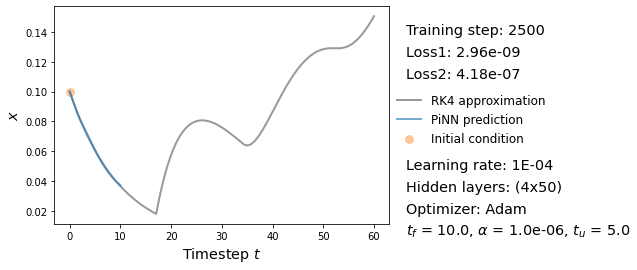

PiNN, iteration: 5000, loss1: 4.9960036108132044e-12, loss2: 1.5623195182001837e-08, time: 0:09:52.539468


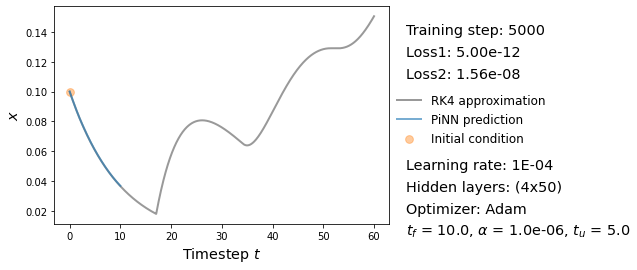

PiNN, iteration: 7500, loss1: 4.496403249731884e-11, loss2: 3.734625941831382e-09, time: 0:10:10.631051


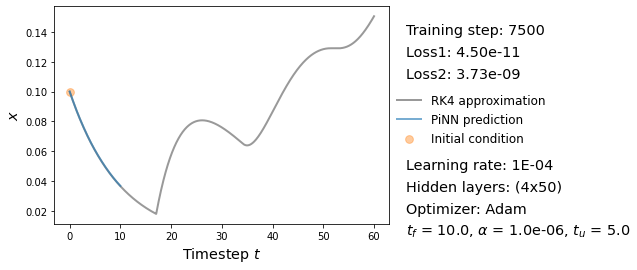

PiNN, iteration: 10000, loss1: 1.4210854715202004e-10, loss2: 1.7272010488511569e-09, time: 0:10:27.097175


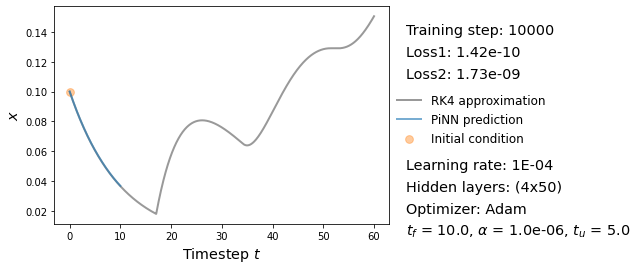

PiNN, iteration: 12500, loss1: 9.381384558082573e-11, loss2: 8.593124545264175e-10, time: 0:10:44.238794


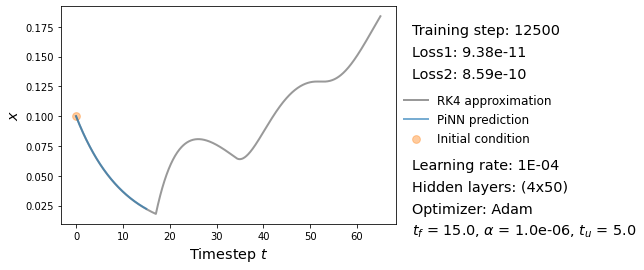

PiNN, iteration: 15000, loss1: 4.904965322793942e-09, loss2: 1.9023747854785e-10, time: 0:11:01.663708


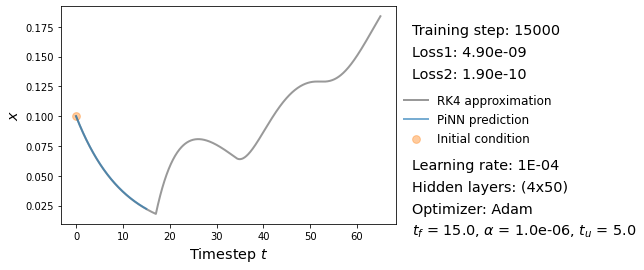

KeyboardInterrupt: ignored

In [18]:
t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training
# Define or load the model ----------------------------------------------------
model = FCN(INPUT,OUTPUT,N_HIDDEN,N_LAYERS) #Create a network with the specified settings
# Following is to load an already trained model -------------------------------
# model.load_state_dict(torch.load("PATHNAME.pth"))
# model.eval()

optimizer = torch.optim.Adam(model.parameters(),lr=lr) #Specify the optimizer and use the learning rate
iteration_help_list = [] #Extra prevention for exploding final time, can only update 10.000 iterations after last update
files_x = [] #Create empty files for the intermediate results for the animation
tf_list = [] #Empty file for updating of the final time 
loss_hist = []
iterations = []
loss = 1
i = 0

while tf < 500:
    optimizer.zero_grad() #Set gradients of all optimized tensors to zero
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/1000
    # t_np = np.random.uniform(ti,tf,n)        #In the case random final times are used in the training
    # t_physics = torch.FloatTensor(t_np).view(-1,1).requires_grad_(True)
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #t_physics needs to be re-specified

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = model(torch.FloatTensor([0]))
    loss1 = (10e3)*torch.mean((m[0]-x0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    px = model(t_physics)
    if tf < tau:
        px_minus_tau = torch.zeros(n) #Zero when tf - tau < 0
    else:
        px_transpose = px.T
        zero_tensor = torch.zeros(int(n/tf*tau))
        px_minus_tau = torch.cat((zero_tensor, px_transpose[0][:-int(n/tf*tau)]), 0) #correct elements should be zero, rest shifted
    px,px_minus_tau = px.view(-1,1),px_minus_tau.view(-1,1) #Correct shape
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    loss2 = torch.mean((a*px_minus_tau/(1 + px_minus_tau**10) - b*px - dxdt)**2)

    loss = loss1 + (10e2)*loss2 #Total loss
    # def closure(): return loss        #for LBFGS, also use optimizer.step(closure)
    loss.backward()   #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step()  #parameter += -lr * parameter.grad

    loss = loss.detach()
    loss_hist.append(loss)
    i += 1        #To keep track of the iterations
    iterations.append(i)
    
    if (i+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("PiNN, iteration: {}, loss1: {}, loss2: {}, time: {}".format(i+1,loss1,loss2,datetime.now() - time))
        xh = torch.squeeze(p.detach()) #PiNN approximation with:
        th = np.linspace(ti,tf,n) #corresponding times
        x = torch.FloatTensor(RungeKutta(MG, x0, float('%.2g'%(tf+50)),n)) #RK4 results with:
        t = np.linspace(ti,tf+50,n) #corresponding times that stays +20 timesteps above the PiNN predicted result

        plot2D(t,x,tf, th,xh, x0, "x") #2D (t,x)-plot
        file = "plots_x/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_x.append(file)
        
        plt.show() #Show plots

    if i%10000 == 0: #Extra prevention to avoid exploding final time. Max 1 update per 10.000 iterations
        iteration_help_list.append(i)
    if len(iteration_help_list) > 0:
        if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
            tf_list.append(tf + update_t)
            iteration_help_list = []

torch.save(model.state_dict(), 'MG_model_weights_{}.pth'.format(iterations))

#Creating gif-animations:
save_gif("pinn_x.gif", files_x, fps=20, loop=0)

# Extension: DHPMs on the Mackey-Glass time series

## Regression Neural Network on MG-series

mkdir: cannot create directory ‘plots’: File exists
Not connected to a GPU
Regression ANN, iteration: 5000, loss: 0.011751120910048485, time: 0:00:54.200393


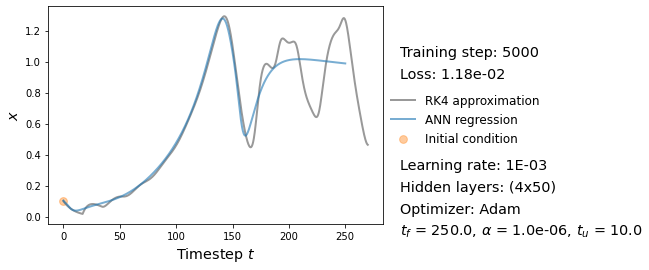

Regression ANN, iteration: 10000, loss: 0.0013303484302014112, time: 0:01:34.061383


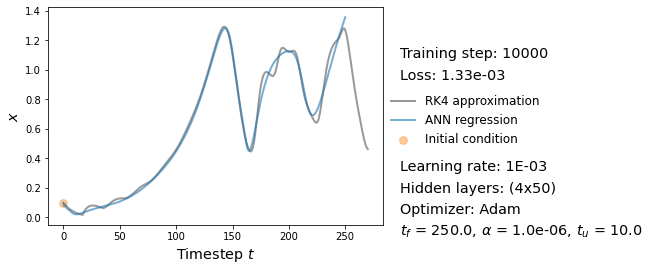

Regression ANN, iteration: 15000, loss: 0.0018381139962002635, time: 0:02:12.294078


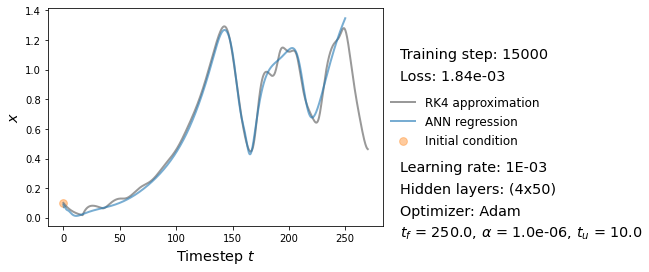

Regression ANN, iteration: 20000, loss: 0.001036469591781497, time: 0:02:49.837301


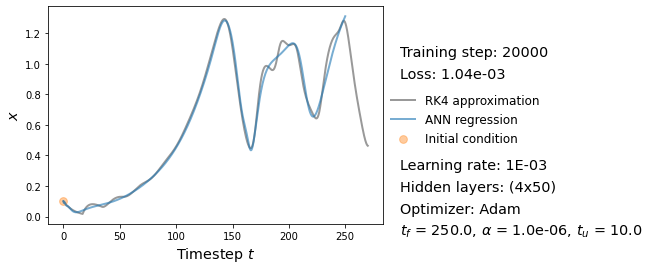

Regression ANN, iteration: 25000, loss: 0.0006124661886133254, time: 0:03:28.021589


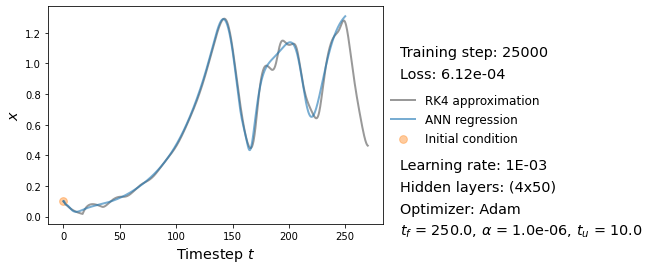

Regression ANN, iteration: 30000, loss: 0.0005690323887392879, time: 0:04:05.501203


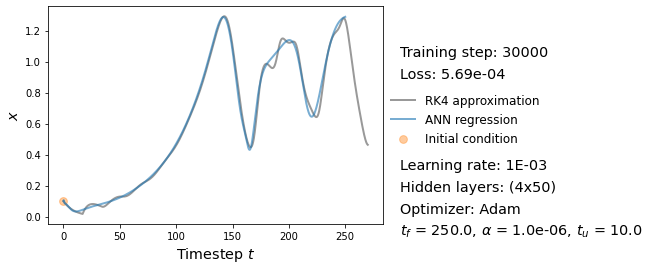

Regression ANN, iteration: 35000, loss: 0.0006840798887424171, time: 0:04:43.536006


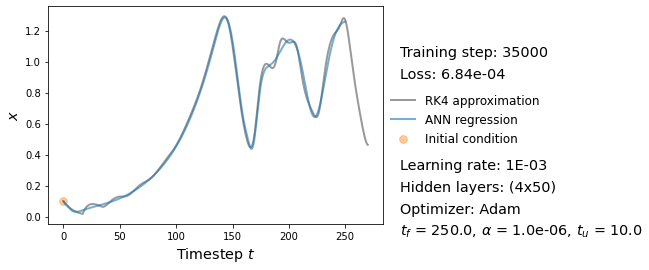

Regression ANN, iteration: 40000, loss: 0.00033721356885507703, time: 0:05:20.783622


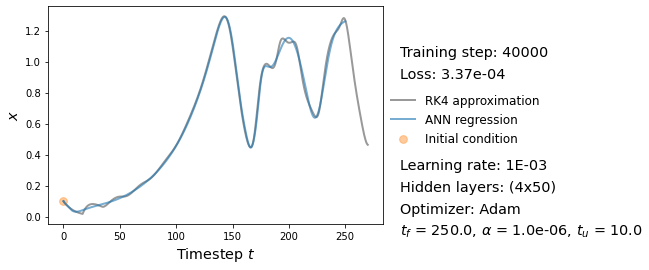

Regression ANN, iteration: 45000, loss: 0.0003671964514069259, time: 0:05:59.571647


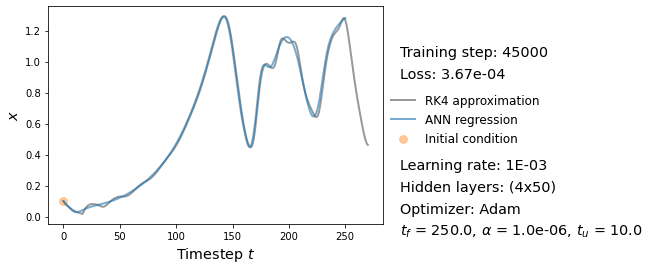

Regression ANN, iteration: 50000, loss: 0.0005775701138190925, time: 0:06:39.845520


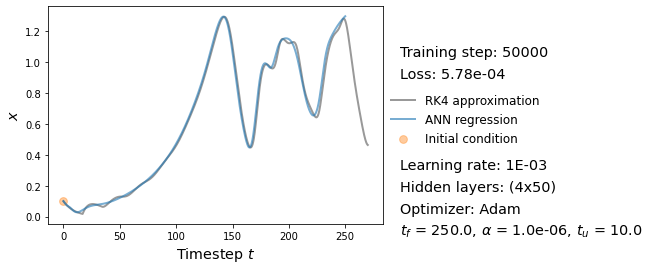

Regression ANN, iteration: 55000, loss: 5.686498116119765e-05, time: 0:07:18.424373


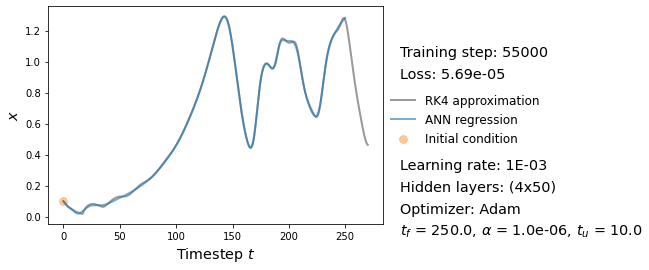

Regression ANN, iteration: 60000, loss: 0.0001433969009667635, time: 0:07:57.260633


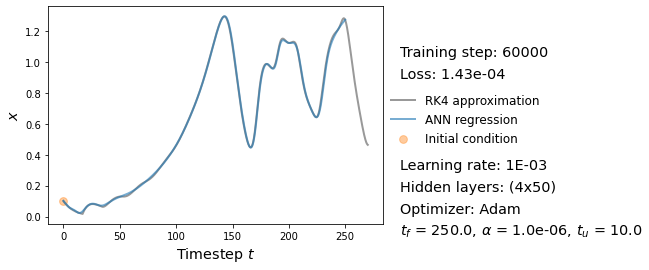

Regression ANN, iteration: 65000, loss: 0.00023653706011828035, time: 0:08:35.300547


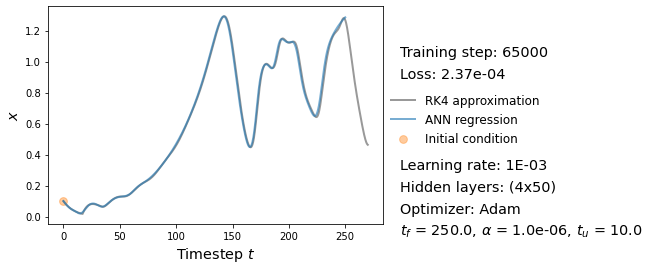

Regression ANN, iteration: 70000, loss: 1.2713172509393189e-05, time: 0:09:12.597843


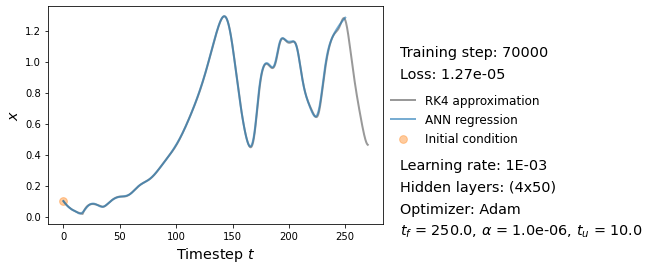

Regression ANN, iteration: 75000, loss: 2.0358165784273297e-05, time: 0:09:49.850551


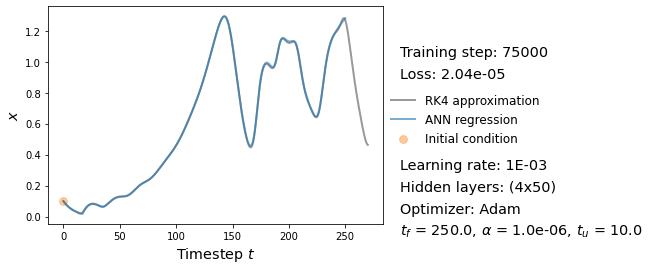

Regression ANN, iteration: 80000, loss: 0.0001755674893502146, time: 0:10:27.092912


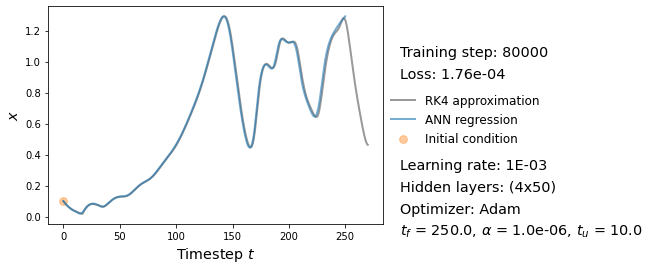

Regression ANN, iteration: 85000, loss: 0.000392773567000404, time: 0:11:04.177782


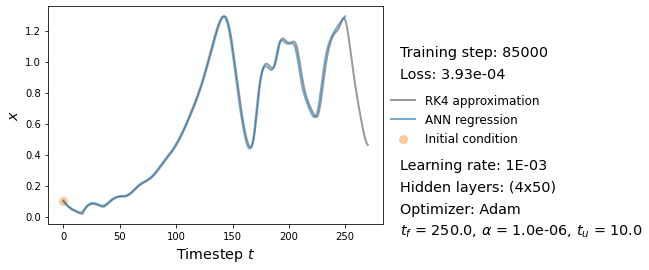

Regression ANN, iteration: 90000, loss: 0.00030833901837468147, time: 0:11:41.896582


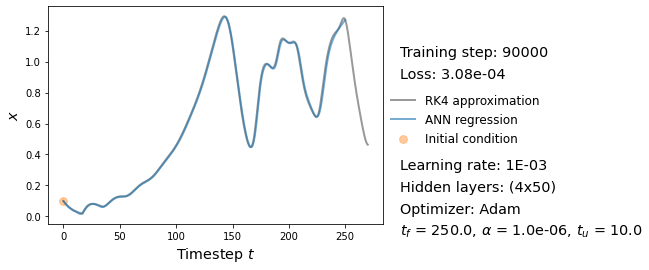

Regression ANN, iteration: 95000, loss: 3.55071242665872e-05, time: 0:12:19.498017


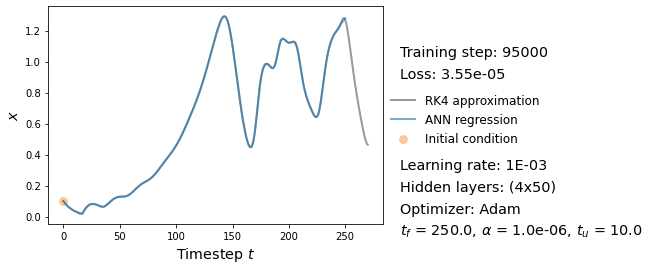

Regression ANN, iteration: 100000, loss: 1.3706381650990807e-05, time: 0:12:56.409676


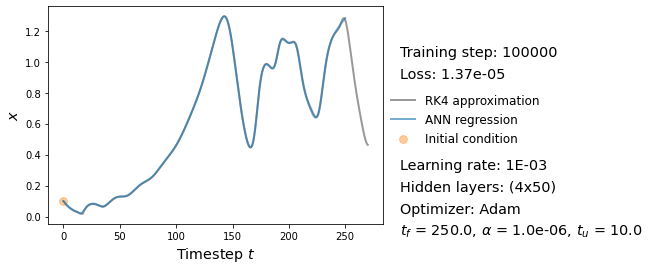

Regression ANN, iteration: 105000, loss: 0.0003053442924283445, time: 0:13:34.293999


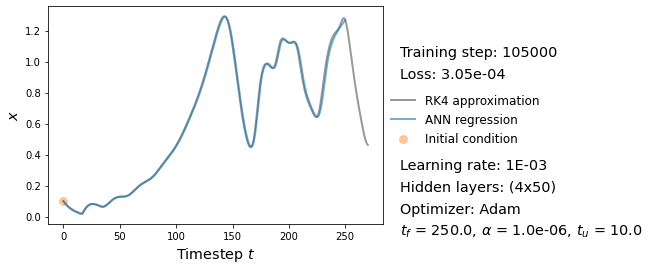

Regression ANN, iteration: 110000, loss: 6.629178096773103e-05, time: 0:14:12.149611


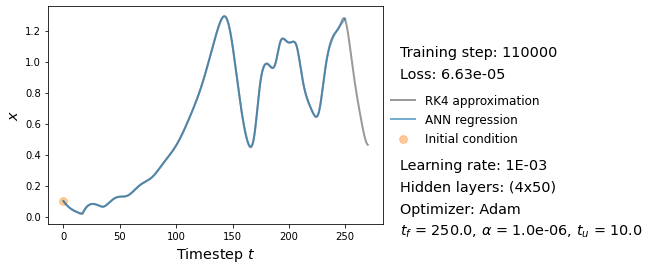

Regression ANN, iteration: 115000, loss: 0.000686136307194829, time: 0:14:49.315259


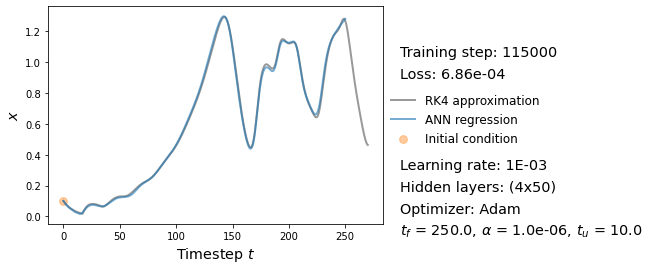

Regression ANN, iteration: 120000, loss: 5.957242683507502e-05, time: 0:15:26.240964


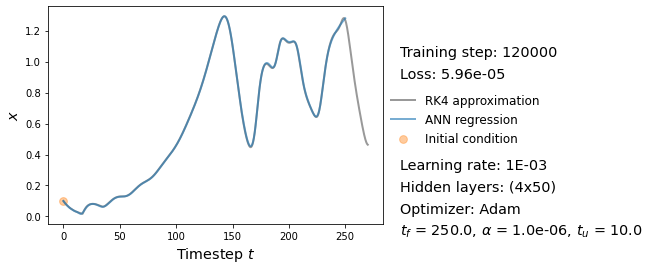

Regression ANN, iteration: 125000, loss: 0.00012633528967853636, time: 0:16:03.350354


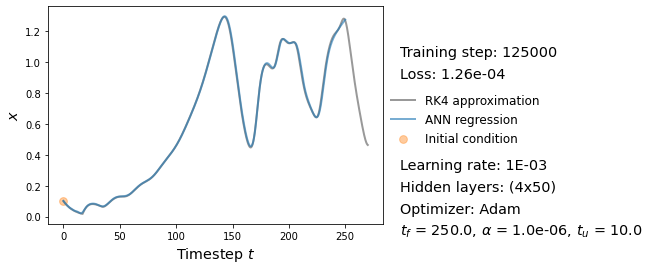

Regression ANN, iteration: 130000, loss: 0.00011504386930027977, time: 0:16:41.229923


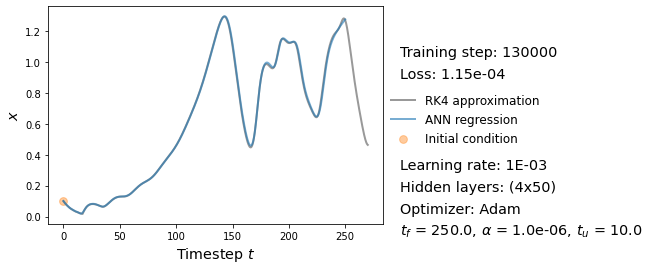

Regression ANN, iteration: 135000, loss: 4.5603272155858576e-05, time: 0:17:19.360030


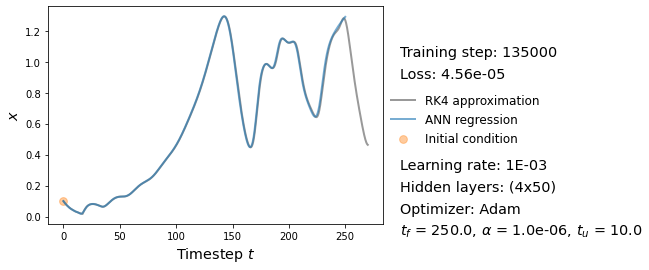

Regression ANN, iteration: 140000, loss: 5.7876273785950616e-05, time: 0:17:57.015860


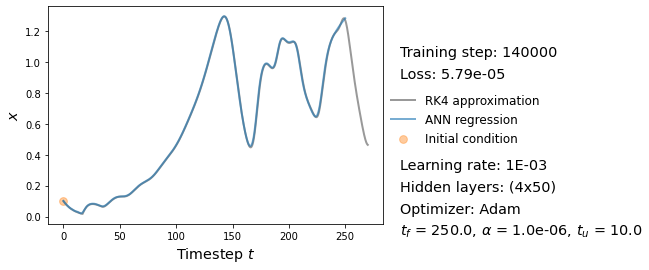

Regression ANN, iteration: 145000, loss: 1.334198623226257e-05, time: 0:18:35.116566


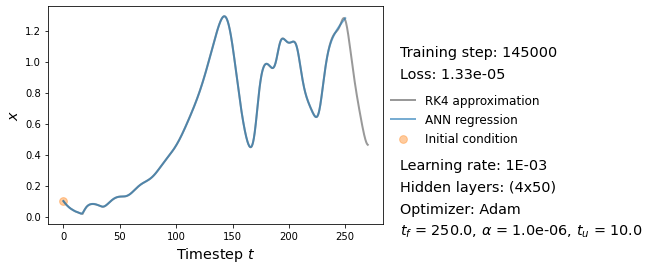

Regression ANN, iteration: 150000, loss: 6.105548527557403e-05, time: 0:19:12.528702


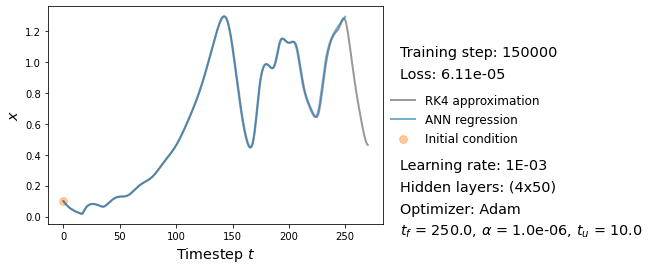

Regression ANN, iteration: 155000, loss: 9.384458098793402e-05, time: 0:19:49.694725


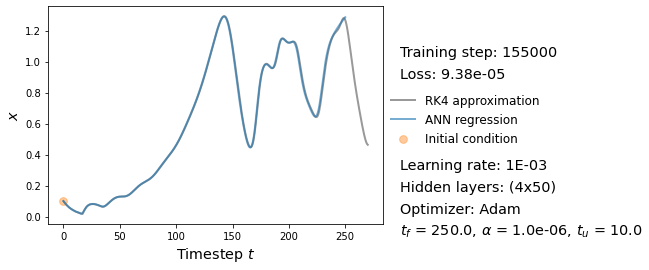

Regression ANN, iteration: 160000, loss: 0.00013060442870482802, time: 0:20:28.833601


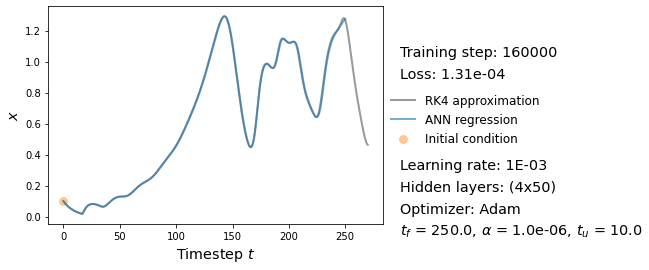

Regression ANN, iteration: 165000, loss: 0.00027714940370060503, time: 0:21:06.821453


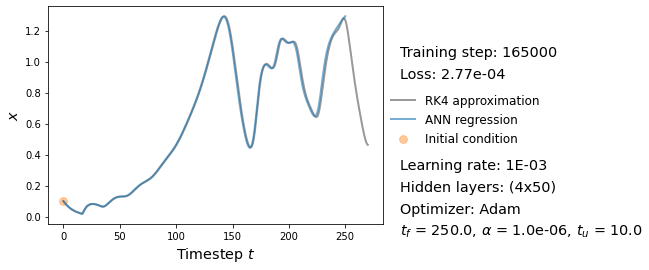

Regression ANN, iteration: 170000, loss: 0.00011116057430626824, time: 0:21:45.167327


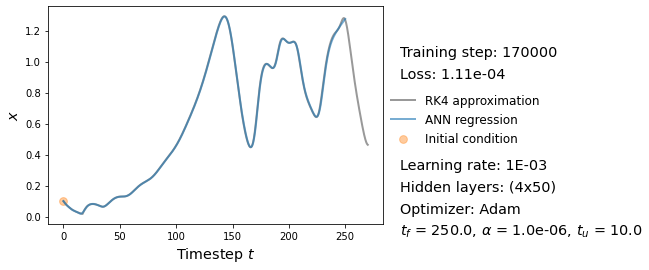

Regression ANN, iteration: 175000, loss: 0.00013668177416548133, time: 0:22:23.065945


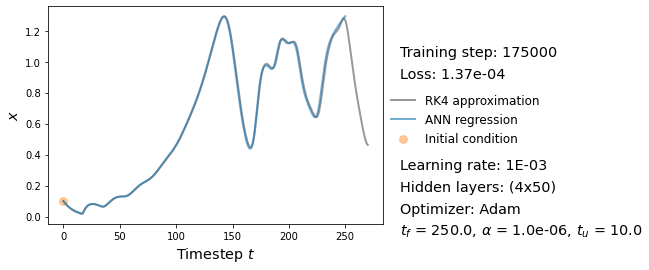

Regression ANN, iteration: 180000, loss: 9.310885070590302e-05, time: 0:23:00.950355


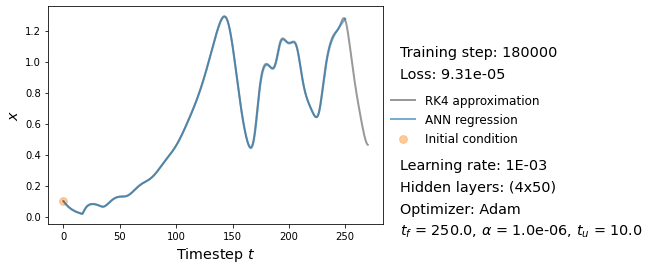

Regression ANN, iteration: 185000, loss: 0.00020383730588946491, time: 0:23:38.624448


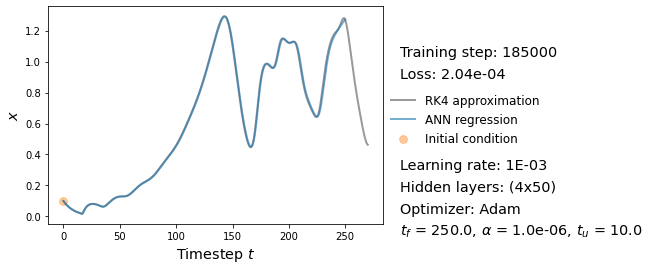

Regression ANN, iteration: 190000, loss: 1.600338327989448e-05, time: 0:24:16.191191


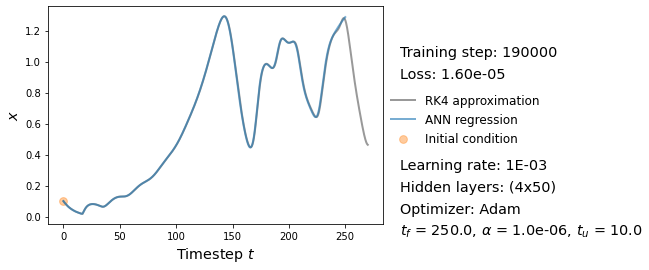

Regression ANN, iteration: 195000, loss: 6.494869012385607e-05, time: 0:24:53.441403


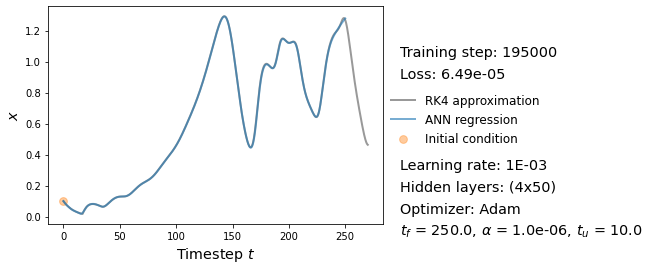

Regression ANN, iteration: 200000, loss: 2.308550028828904e-05, time: 0:25:30.312584


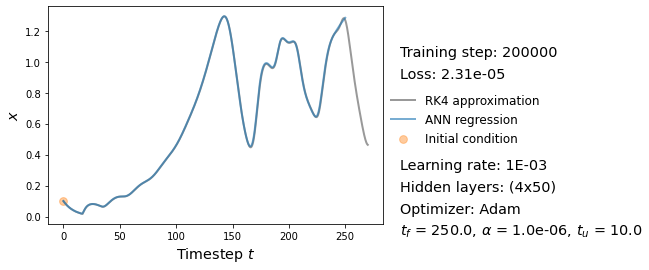

Regression ANN, iteration: 205000, loss: 1.2040703950333409e-05, time: 0:26:07.508548


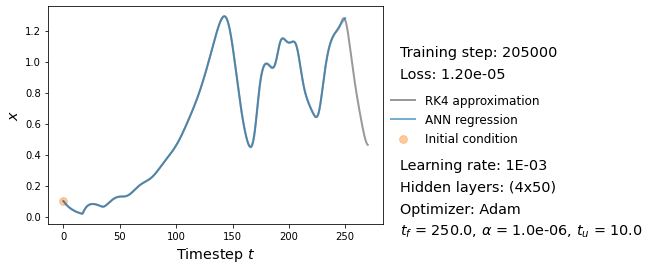

Regression ANN, iteration: 210000, loss: 0.00020702797337435186, time: 0:26:45.443929


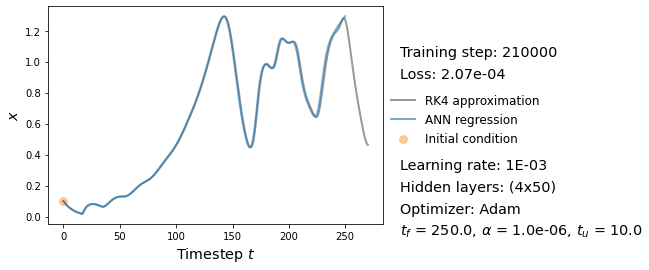

Regression ANN, iteration: 215000, loss: 0.00016364232578780502, time: 0:27:24.875210


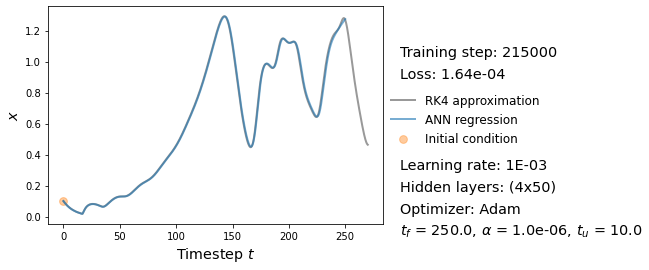

Regression ANN, iteration: 220000, loss: 1.5886851542745717e-05, time: 0:28:03.229615


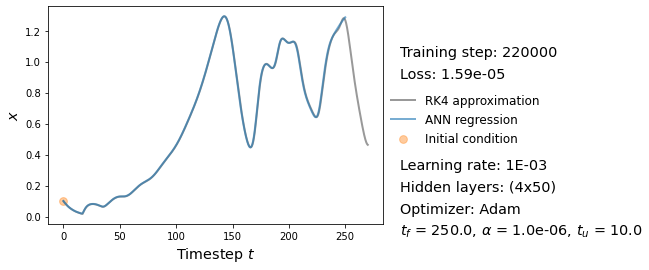

Regression ANN, iteration: 225000, loss: 0.00023415252508129925, time: 0:28:42.176656


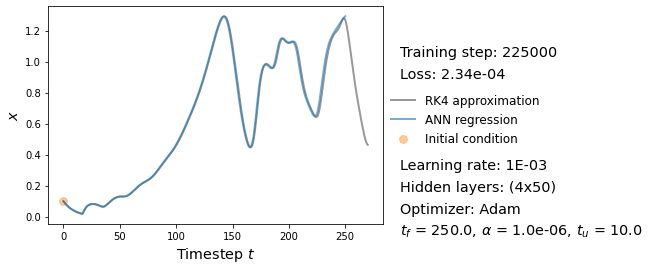

Regression ANN, iteration: 230000, loss: 1.0638186722644605e-05, time: 0:29:20.366096


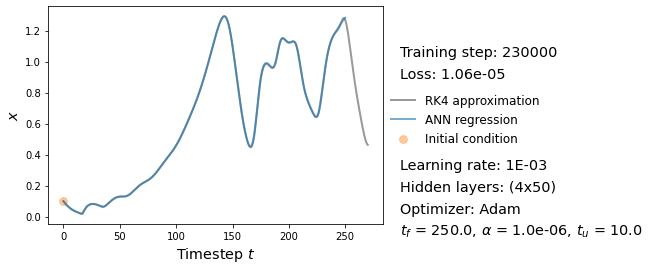

Regression ANN, iteration: 235000, loss: 1.8435646779835224e-05, time: 0:29:59.270761


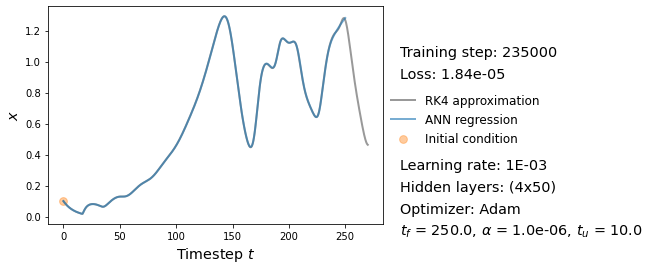

Regression ANN, iteration: 240000, loss: 5.392132152337581e-06, time: 0:30:37.639426


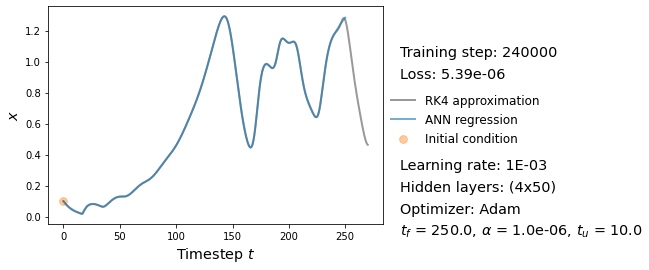

Regression ANN, iteration: 245000, loss: 8.81313462741673e-06, time: 0:31:15.507150


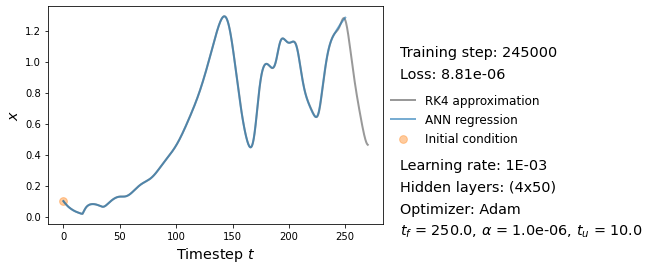

Regression ANN, iteration: 250000, loss: 8.49881544127129e-05, time: 0:31:52.332194


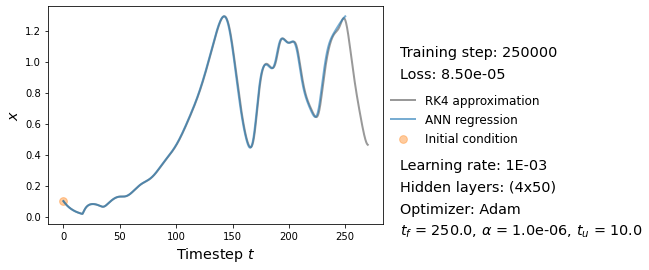

Regression ANN, iteration: 255000, loss: 0.00020952157501596957, time: 0:32:29.227763


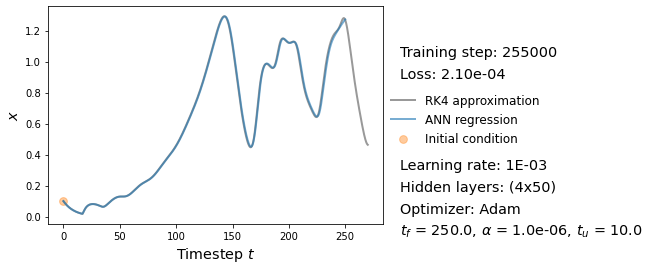

Regression ANN, iteration: 260000, loss: 8.441280806437135e-05, time: 0:33:07.416593


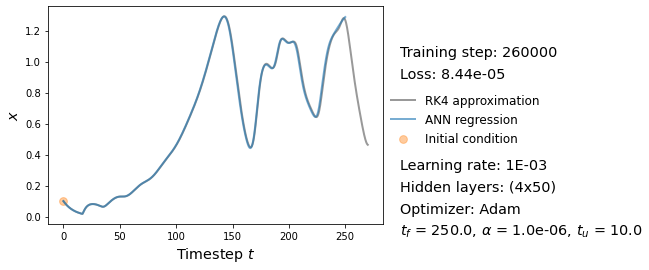

Regression ANN, iteration: 265000, loss: 5.74531513848342e-05, time: 0:33:44.321317


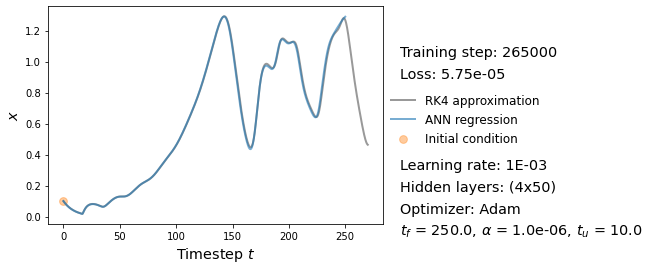

Regression ANN, iteration: 270000, loss: 8.003987750271335e-05, time: 0:34:20.842407


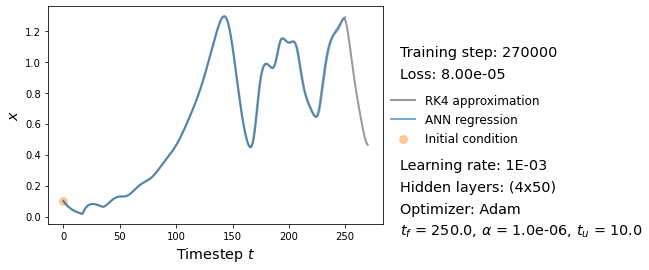

Regression ANN, iteration: 275000, loss: 0.00020115115330554545, time: 0:34:57.528672


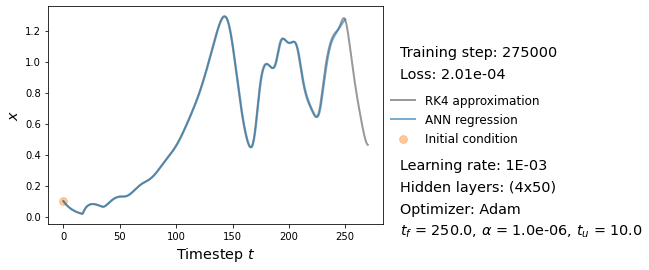

Regression ANN, iteration: 280000, loss: 5.405523188528605e-05, time: 0:35:34.646822


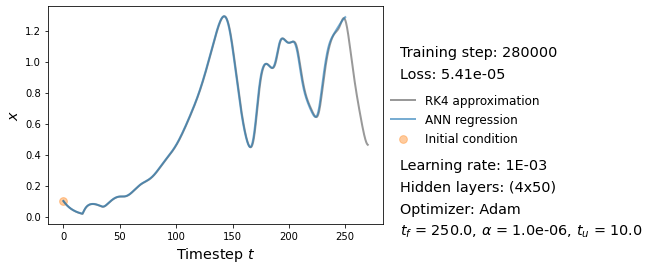

Regression ANN, iteration: 285000, loss: 0.00031944504007697105, time: 0:36:11.423874


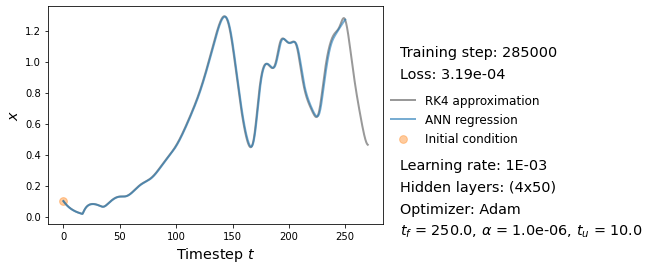

Regression ANN, iteration: 290000, loss: 2.5217064830940217e-05, time: 0:36:48.631090


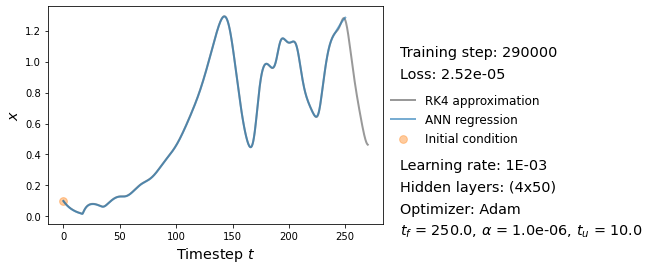

Regression ANN, iteration: 295000, loss: 2.6736021027318202e-05, time: 0:37:25.470488


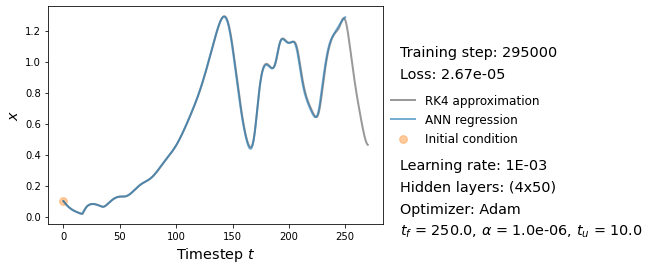

Regression ANN, iteration: 300000, loss: 5.311574204824865e-05, time: 0:38:02.105797


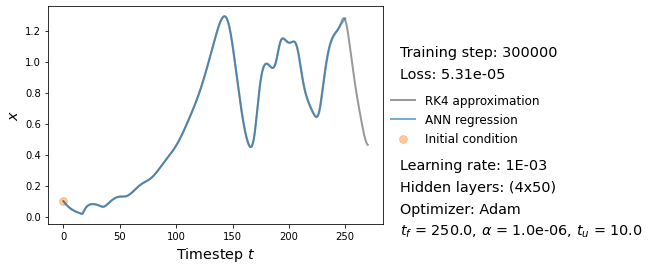

Regression ANN, iteration: 305000, loss: 2.7655976737150922e-05, time: 0:38:40.131583


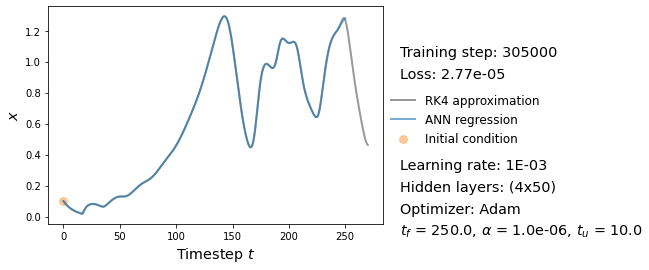

Regression ANN, iteration: 310000, loss: 0.0001296492264373228, time: 0:39:16.584114


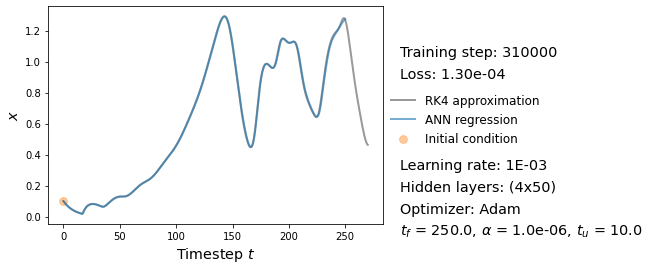

Regression ANN, iteration: 315000, loss: 8.074713150563184e-06, time: 0:39:52.937471


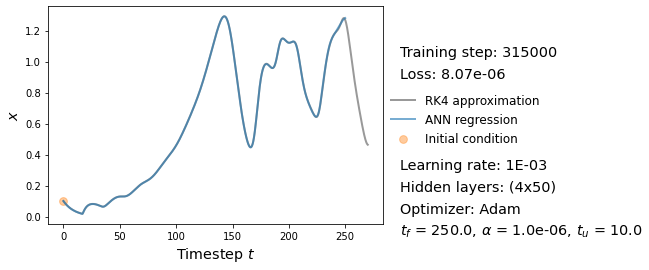

Regression ANN, iteration: 320000, loss: 4.902470391243696e-05, time: 0:40:29.232243


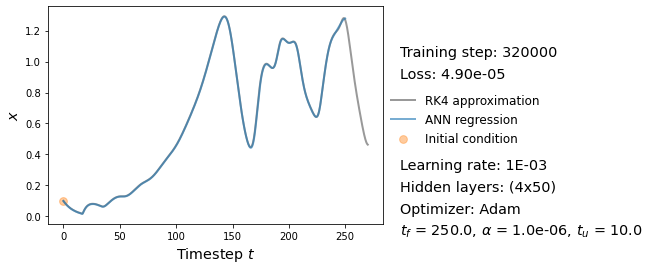

Regression ANN, iteration: 325000, loss: 0.00010722375736804679, time: 0:41:04.684738


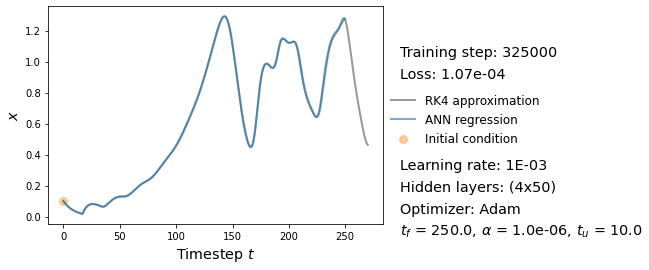

Regression ANN, iteration: 330000, loss: 2.5122749320871662e-06, time: 0:41:41.404837


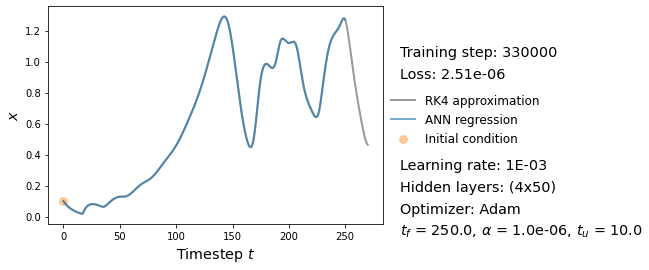

Regression ANN, iteration: 335000, loss: 0.0001617262460058555, time: 0:42:17.463646


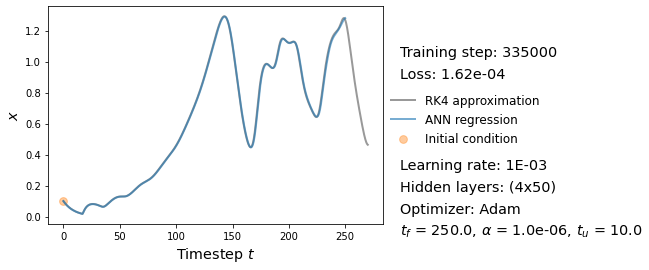

In [ ]:
# Expected runtime: 0:53:50.180070

!mkdir plots

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from datetime import datetime
time = datetime.now()

warnings.simplefilter(action='ignore', category=FutureWarning)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
torch.manual_seed(12345)
np.random.seed(12345)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

#=============================================================================
#============================  Definitions  ==================================
#=============================================================================
# Fully Connected Network ----------------------------------------------------
class FCN(nn.Module): 
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh #Specify the used activation function
        self.fc1 = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()]) #Input to first hidden layer
        self.fc2 = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)]) #Going through the remaining hidden layers
        self.fc3 = nn.Linear(N_HIDDEN, N_OUTPUT) #Last hidden layer to output layer

    def forward(self, *args):
        if len(args) == 1: #When multiple initial conditions are specified, this will provide the correct shape. 
            x = args[0]
        elif len(np.shape(args[0])) <= 1:
            x = torch.FloatTensor([*args]).T
        else:
            x = torch.FloatTensor(torch.cat([*args], 1))

        x = self.fc1(x) #Going to the layers
        x = self.fc2(x)
        x = self.fc3(x)
        return x

# Runge Kutta fourth order method ---------------------------------------------
def RungeKutta(dxdt, x0, tf, n): # Specify derivatives, initial conditions and time
    h = tf/n   #Stepsize
    xl = n*[0] #Create lists for output
    xl[0] = x0 #First element in outputlist is initial condition
    for i in range(1,n): #Loop over steps while skipping the first one due to the initial condition
        x_t = xl[i-1]
        if i-1 >= n/tf*tau:
            x_t_minus_tau = xl[int(i-1-n/tf*tau)]
        else: 
            x_t_minus_tau = 0

        #Going through the four RK4 equations:
        k1x = h*dxdt(x_t, x_t_minus_tau)
        xs  = x_t + 0.5*k1x
        xs_minus_tau = x_t_minus_tau + 0.5*k1x
        k2x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + 0.5*k2x  
        xs_minus_tau = x_t_minus_tau + 0.5*k2x
        k3x = h*dxdt(xs, xs_minus_tau)
        xs  = x_t + k3x
        xs_minus_tau = x_t_minus_tau + k3x
        k4x = h*dxdt(xs, xs_minus_tau)
        #Update last next value in output list:
        xl[i] = x_t + (k1x + 2*k2x + 2*k3x + k4x)/6 
    return xl

# ----------------------------------------------------------------------------- 
# -------------- 2D plot of RK4 approximation and ANN regression -------------- 
# ----------------------------------------------------------------------------- 
def plot2D(T,X1,tf, t,pred, init, axis):
    plt.figure()
    plt.plot(T, X1, color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t, pred, color="tab:blue", linewidth=2, alpha=0.6, label="ANN regression")
    plt.scatter(t[0],init, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
    plt.annotate("Training step: %i"%(i+1),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss: {:.2e}".format(loss),xy=(1.05, 0.67),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Learning rate: %.0E"%(lr),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Hidden layers: ({}x{})".format(N_LAYERS, N_HIDDEN),xy=(1.05, 0.15),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Optimizer: Adam",xy=(1.05, 0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.1f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1f}".format(tf, alpha, update_t),xy=(1.05, -0.05),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('${}$'.format(axis), fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)


# ----------------------------------------------------------------------------- 
# ----------------- Mackey Glass time series parameters ----------------------- 
# ----------------------------------------------------------------------------- 
x0 = 0.1               #Initial conditions
a,b,tau = 0.2,0.1,17 #Parameters of the system
ti = 0               #Initial time
tf = 250              #Starting final time (without update)
n = 1000             #Steps taken between ti and tf
h = tf/n             #Step size of each step of n

# ----------------------------------------------------------------------------- 
# ------------------------------ PiNN parameters ------------------------------ 
# ----------------------------------------------------------------------------- 
lr = 1e-3            #Learning rate
INPUT = 1            #Amount of inputs
N_HIDDEN = 50        #Amount of hidden layers
N_LAYERS = 4         #Amount of neurons in hidden layers
OUTPUT = 1           #Amount of outputs
alpha = 0.000001    #Threshold value for updating tf with update_t
update_t = 10        #Update value for tf after reaching threshold
intermediate = 5000  #Safe intermediate results after every {intermediate} iterations

# ----------------------------------------------------------------------------- 
# ------------------- Mackey Glass differential equation ---------------------- 
# ----------------------------------------------------------------------------- 
def MG(x_t, x_t_minus_tau):
    return a*x_t_minus_tau/(1 + x_t_minus_tau**10) - b*x_t


#=============================================================================
#=========================  Identification ANN  ==============================
#=============================================================================

# Define the model -----------------------------------------------------------
model = FCN(1,1,N_HIDDEN,N_LAYERS) #Create a network with the specified hidden layers and neurons
optimizer = torch.optim.Adam(model.parameters(),lr=lr) #Specify the optimizer and use the learning rate

tf_list = []
files = [] #Create empty file for the intermediate results for the animation
iterations = []
loss_hist = []
i=0
while tf < 251: #Loop over the iterations (and stop when tf = 250 is reached and empirically converged)
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training
    x = torch.FloatTensor(RungeKutta(MG, x0, tf,n))

    optimizer.zero_grad() #Set gradients of all optimized tensors to zero

    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n
    t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = model(torch.FloatTensor([0]))
    loss1 = torch.mean((m[0]-x0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    px = model(t_physics)
    x = x.view(-1,1)
    loss2 = torch.mean((x-px)**2)

    loss = 10*loss1 + loss2 #Total loss
    # def closure(): return loss        #for LBFGS, also use optimizer.step(closure)
    loss.backward()   #parameter.grad += dloss/d(parameter), for every parameter (the weight/bias matrices)
    optimizer.step()  #parameter += -lr * parameter.grad
    
    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
        tf_list.append(tf + update_t)
    loss = loss.detach()
    loss_hist.append(loss)

    i += 1        #To keep track of the iterations
    iterations.append(i)

    if (iterations[-1]+1)%intermediate == 0: #Plot and save intermediate results
        t_physics = torch.linspace(ti,tf,n).view(-1,1).requires_grad_(True)
        p = model(t_physics)
        print("Regression ANN, iteration: {}, loss: {}, time: {}".format(i+1,loss,datetime.now() - time))
        xh = torch.squeeze(p.detach()) #PiNN approximation with:
        th = torch.linspace(ti,tf,n).view(-1,1) #corresponding times
        x = torch.FloatTensor(RungeKutta(MG, x0, float('%.2g'%(tf+20)),n)) #RK4 results with:
        t = torch.linspace(ti,tf+20,n).view(-1,1) #corresponding times that stays +20 timesteps above the ANN predicted result

        plot2D(t,x,tf, th,xh, x0, "x") #2D (t,x)-plot
        file = "plots/pinn_%.7i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        plt.show() #Show plots

torch.save(model.state_dict(), 'ANN_model_weights.pth')

#Creating gif-animations:
save_gif("regression.gif", files, fps=20, loop=0)

In [ ]:
torch.save(model.state_dict(), 'ANN_model_weights.pth')

#Creating gif-animations:
save_gif("regression.gif", files, fps=20, loop=0)

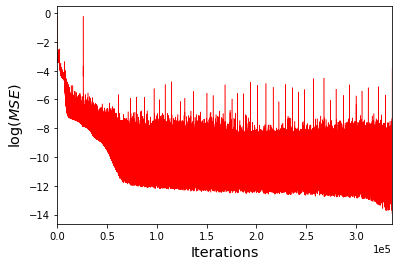

tensor(0.0212)


In [ ]:
# Plot of the loss during every iteration in the regression ANN training ------
plt.plot(np.arange(0,len(loss_hist),1), np.array(np.log(loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$\\log(MSE)$', fontsize='x-large')
plt.xlim(0,len(loss_hist))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) #Scientific numbers on x-axis
plt.savefig('loss_history_1.png')
plt.show()
print(loss_hist[-1])

In [ ]:
# Expected runtime: 0:05:54.198006, epochs needed = 24000
time = datetime.now()
torch.manual_seed(12345)
np.random.seed(12345)

# Takes in a module and applies the Xavier weight initialization --------------
def weights_init_xavier_rule(m):
  classname = m.__class__.__name__
  #for every Linear layer in a model:
  if classname.find('Linear') != -1:
      torch.nn.init.xavier_normal_(m.weight)
      m.bias.data.fill_(0)

class OdeNet(nn.Module):
    def __init__(self, t, ode_layers, activation_fun=nn.Tanh):
        super(OdeNet, self).__init__()

        self.act_fun = activation_fun()

        self.hidden_layers = [nn.Linear(ode_layers[0], ode_layers[1])]
        for idx, width in enumerate(ode_layers[1:-1]):
          if idx < (len(ode_layers[1:-1]) - 1):
            self.hidden_layers.append(nn.Linear(width, ode_layers[idx + 2]))

        self.output_layer = nn.Linear(ode_layers[-2], ode_layers[-1]) 

        self.fnn = self.layers()

    def forward(self, t):
        ode = self.fnn(t)
        return ode

    def layers(self):
        modules = []
        for idx, layer in enumerate(self.hidden_layers):
            modules.append(layer)
            modules.append(self.act_fun)
        modules.append(self.output_layer)
        return nn.Sequential(*modules)

# (Hyper)parameters of the training -------------------------------------------
ode_layers = [1, 100,100, 1]    #Specify the layers used in the model
lr = 0.001                      #Learning rate
n = 1000                        #Steps taken
tf = 250                        #Final time
intermediate = 1000             #For plotting of intermediate results
iterations = []                 #Keeping track of the iterations executed
loss_ode_hist = []              #Keeping track of the loss
e = 0                           #Used as initial iteration
idn_ode_loss = 1                #Used to initiate the while-loop

# Autograd --------------------------------------------------------------------
t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
xhat = model.forward(t)   #Forward t through the model which outputs x,y,z
xhat_t = torch.autograd.grad(xhat, t, torch.ones_like(xhat), create_graph=True)[0]

# Define the identification ANN -----------------------------------------------
model_ode = OdeNet(t, ode_layers)
model_ode.apply(weights_init_xavier_rule)
for i in range(len(ode_layers)-2): #Xavier initialization
  model_ode.hidden_layers[i].apply(weights_init_xavier_rule)
ode_optimizer = torch.optim.Adam(model_ode.parameters(), lr=lr) #Optimizer using specified learning rate

while idn_ode_loss > 0.0001: #Loop over the iterations (and stop when idn_ode_loss < 0.01). 
    ode_optimizer.zero_grad()
    N_pred_x = model_ode.forward(t)
    N_pred_x = N_pred_x.view(-1,1)
    idn_ode_loss = torch.mean(torch.square(xhat_t - N_pred_x))

    idn_ode_loss.backward(retain_graph=True)
    # def closure(): return idn_ode_loss
    ode_optimizer.step()

    idn_ode_loss = idn_ode_loss.detach() #This prevents the RAM from blowing up due to the retain_graph=True
    loss_ode_hist.append(idn_ode_loss)

    e += 1        #To keep track of the iterations/epochs
    iterations.append(e)

    if e%intermediate == 0: #Plotting of intermediate results
        print("epoch = %6d" % iterations[-1], end="")
        print("  epoch loss = %10.8f" % idn_ode_loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")

torch.save(model_ode.state_dict(), 'ANN_model_ode_weights.pth')

epoch =   1000  epoch loss = 0.00026855  time: 0:00:07.627130

epoch =   2000  epoch loss = 0.00026850  time: 0:00:14.453514

epoch =   3000  epoch loss = 0.00026988  time: 0:00:21.112808

epoch =   4000  epoch loss = 0.00027605  time: 0:00:27.772099

epoch =   5000  epoch loss = 0.00026847  time: 0:00:34.797737

epoch =   6000  epoch loss = 0.00026835  time: 0:00:45.124565

epoch =   7000  epoch loss = 0.00026844  time: 0:00:51.859630

epoch =   8000  epoch loss = 0.00026864  time: 0:00:58.616398

epoch =   9000  epoch loss = 0.00027185  time: 0:01:05.315964

epoch =  10000  epoch loss = 0.00026866  time: 0:01:11.939895

epoch =  11000  epoch loss = 0.00026884  time: 0:01:18.529578

epoch =  12000  epoch loss = 0.00027419  time: 0:01:25.177498

epoch =  13000  epoch loss = 0.00026959  time: 0:01:31.869977

epoch =  14000  epoch loss = 0.00027106  time: 0:01:38.620352

epoch =  15000  epoch loss = 0.00026885  time: 0:01:45.392951

epoch =  16000  epoch loss = 0.00027280  time: 0:01:52.

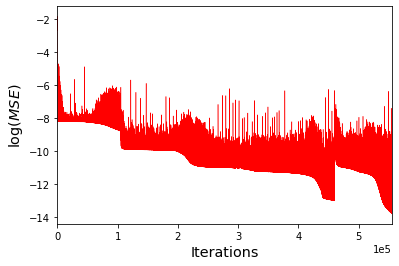

tensor(9.9982e-07)


In [ ]:
plt.plot(iterations, np.array(np.log(loss_ode_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$\\log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0)) #Scientific numbers on x-axis
plt.savefig('loss_history_ode2.png')
plt.show()
print(loss_ode_hist[-1])

mkdir: cannot create directory ‘PiNN_plots_x’: File exists
epoch =   5000  epoch loss = 0.00029721  time: 0:00:51.071391



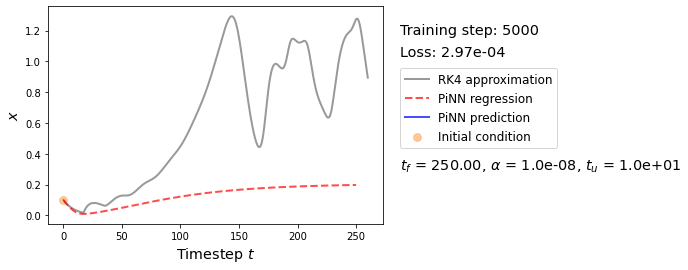

epoch =  10000  epoch loss = 0.00036766  time: 0:01:41.550409



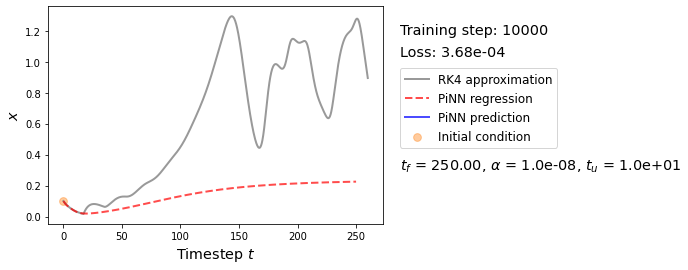

epoch =  15000  epoch loss = 0.00022201  time: 0:02:32.807010



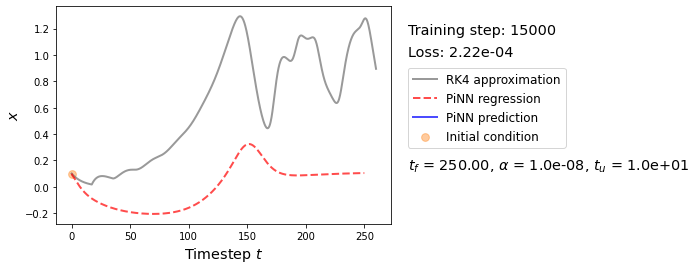

epoch =  20000  epoch loss = 0.00026076  time: 0:03:21.882554



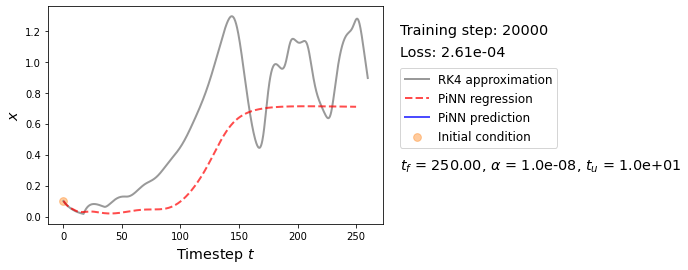

epoch =  25000  epoch loss = 0.00030474  time: 0:04:09.474967



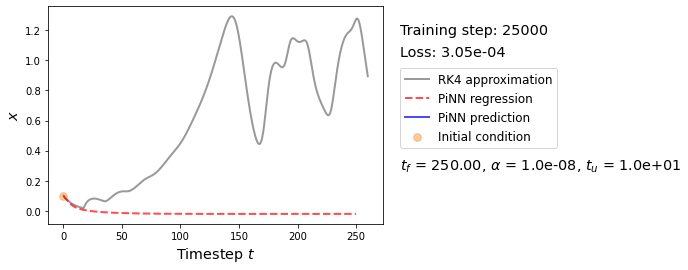

epoch =  30000  epoch loss = 0.00030368  time: 0:04:56.507070



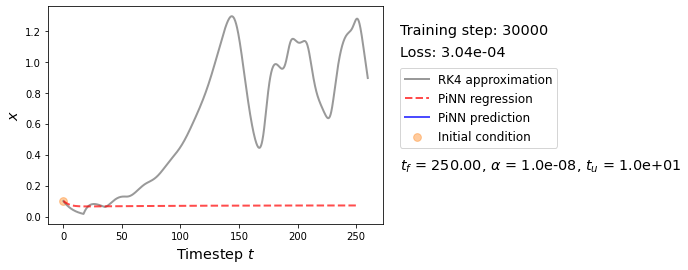

epoch =  35000  epoch loss = 0.00028436  time: 0:05:43.621168



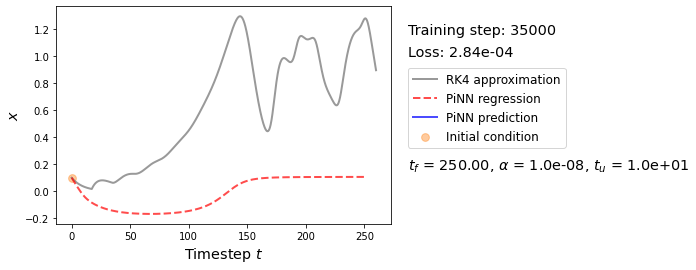

epoch =  40000  epoch loss = 0.00025951  time: 0:06:36.557812



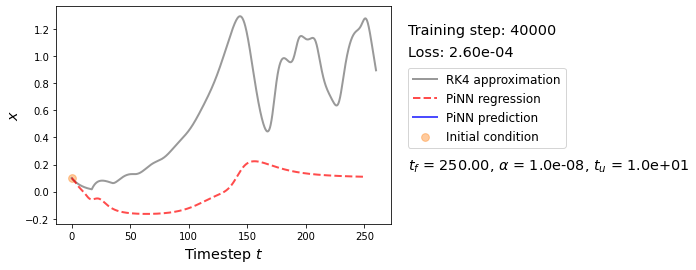

epoch =  45000  epoch loss = 0.00002959  time: 0:07:36.078534



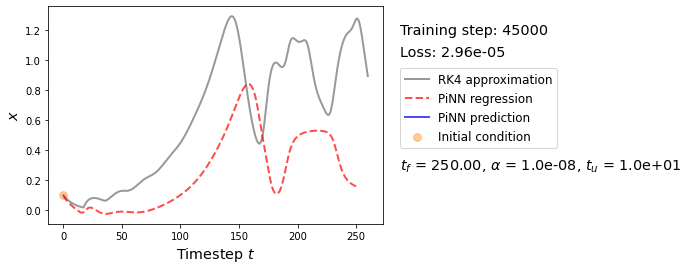

epoch =  50000  epoch loss = 0.00001706  time: 0:08:34.145446



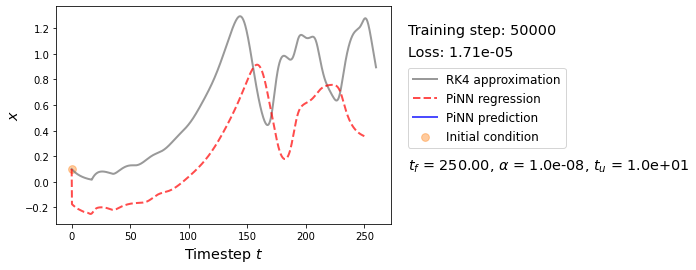

epoch =  55000  epoch loss = 0.00001059  time: 0:09:23.709222



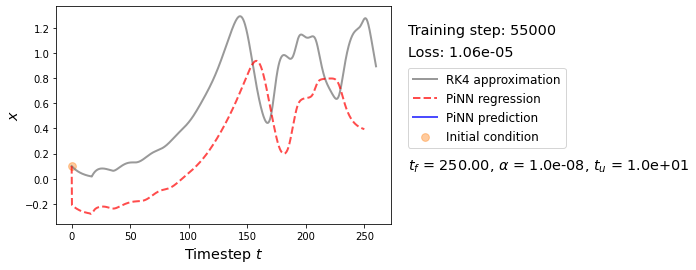

epoch =  60000  epoch loss = 0.00002959  time: 0:10:17.133168



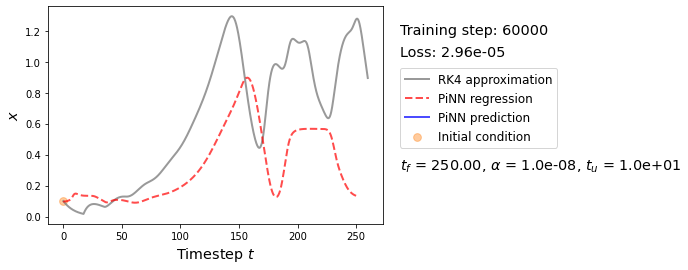

epoch =  65000  epoch loss = 0.00001776  time: 0:11:20.962826



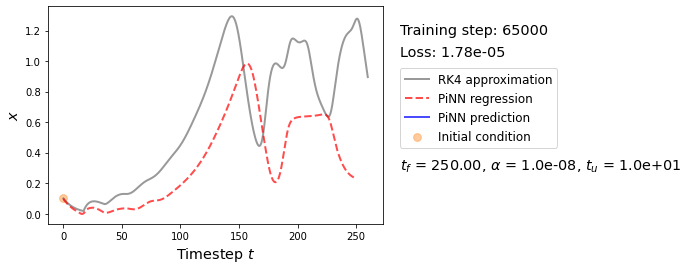

epoch =  70000  epoch loss = 0.00000909  time: 0:12:32.441991



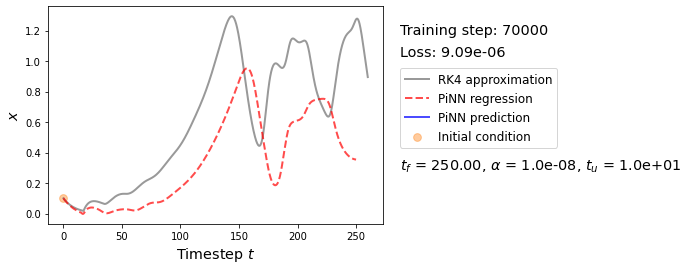

epoch =  75000  epoch loss = 0.00000510  time: 0:13:32.629379



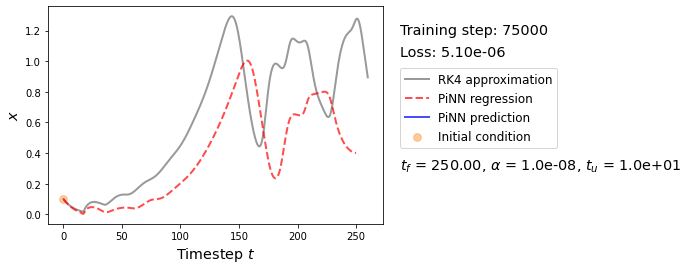

epoch =  80000  epoch loss = 0.00000838  time: 0:14:32.180422



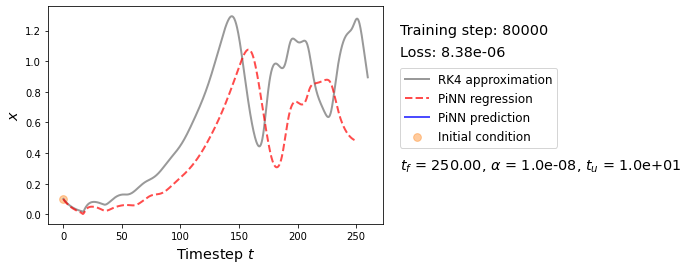

epoch =  85000  epoch loss = 0.00001293  time: 0:15:18.563636



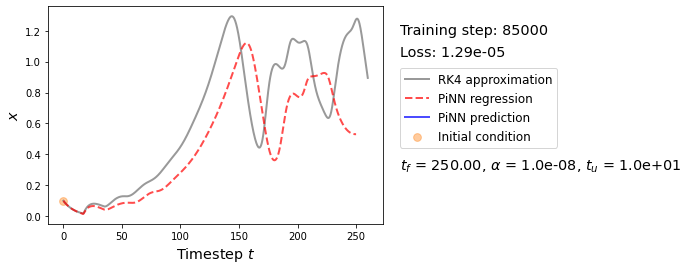

epoch =  90000  epoch loss = 0.00001134  time: 0:16:03.411404



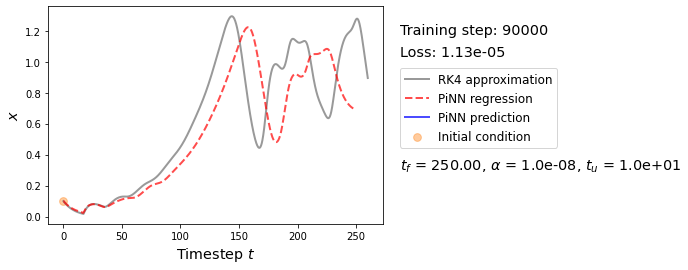

epoch =  95000  epoch loss = 0.00000085  time: 0:16:48.060852



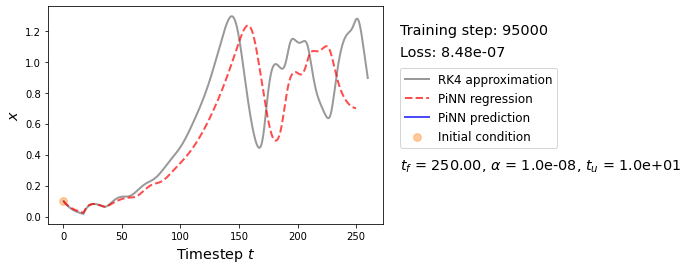

epoch = 100000  epoch loss = 0.00000756  time: 0:17:34.393542



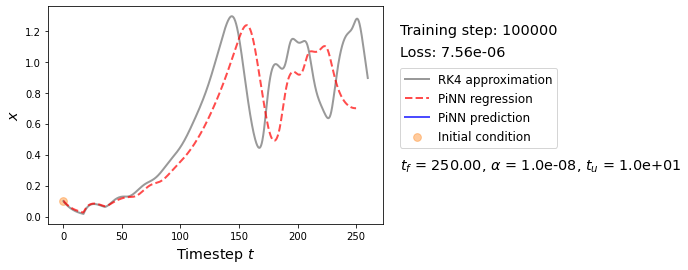

epoch = 105000  epoch loss = 0.00000165  time: 0:18:20.188251



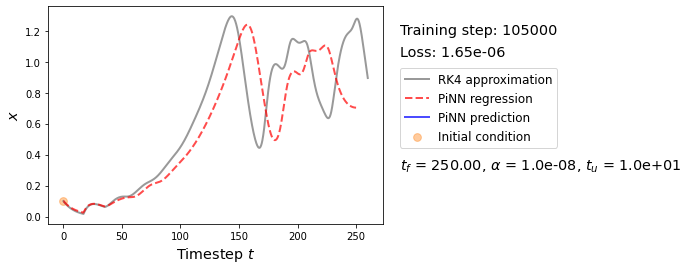

epoch = 110000  epoch loss = 0.00000555  time: 0:19:06.186564



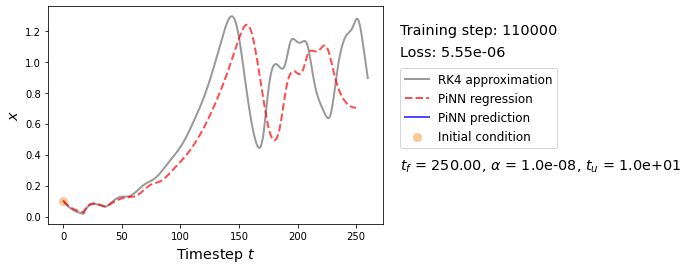

epoch = 115000  epoch loss = 0.00000118  time: 0:19:51.351894



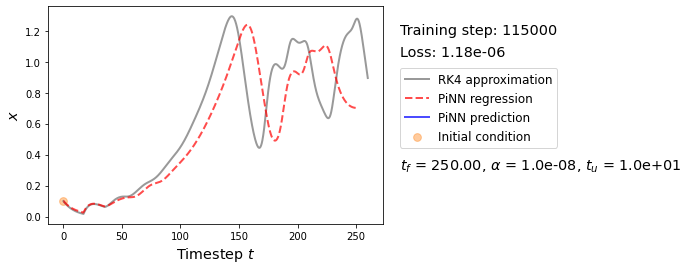

epoch = 120000  epoch loss = 0.00000222  time: 0:20:36.810613



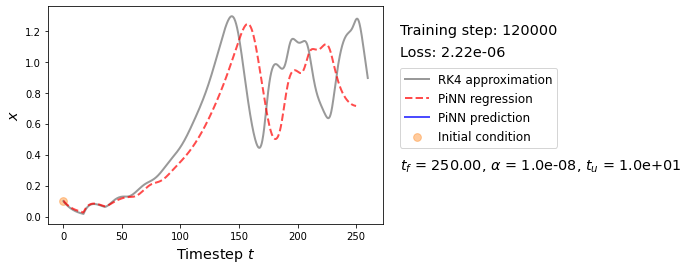

epoch = 125000  epoch loss = 0.00000214  time: 0:21:21.250979



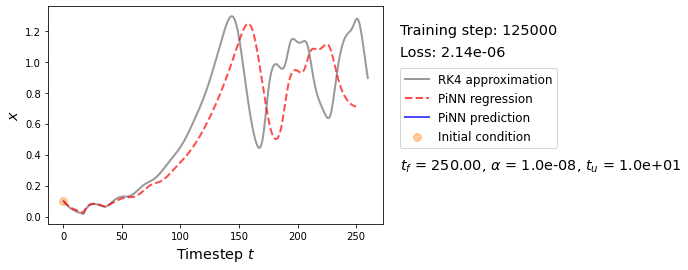

epoch = 130000  epoch loss = 0.00000117  time: 0:22:05.981708



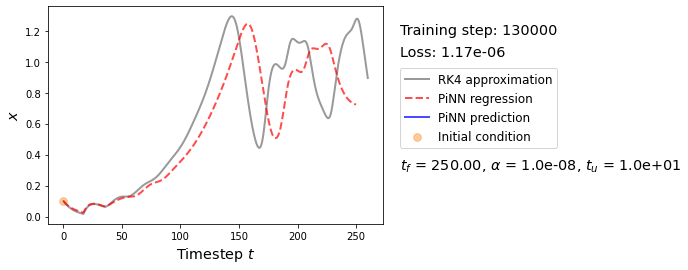

epoch = 135000  epoch loss = 0.00000191  time: 0:22:50.750738



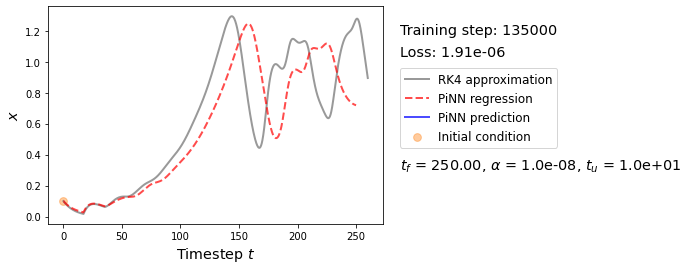

epoch = 140000  epoch loss = 0.00000019  time: 0:23:35.268602



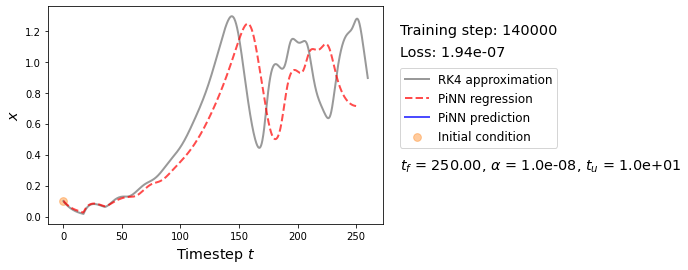

epoch = 145000  epoch loss = 0.00000069  time: 0:24:20.039826



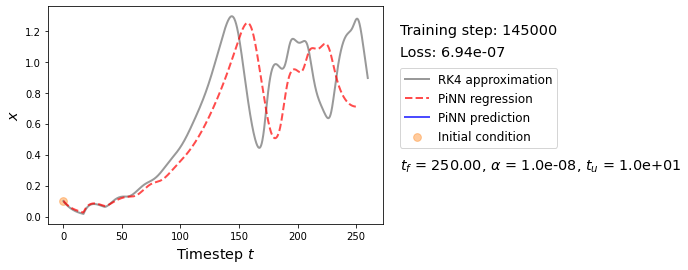

epoch = 150000  epoch loss = 0.00000015  time: 0:25:06.122800



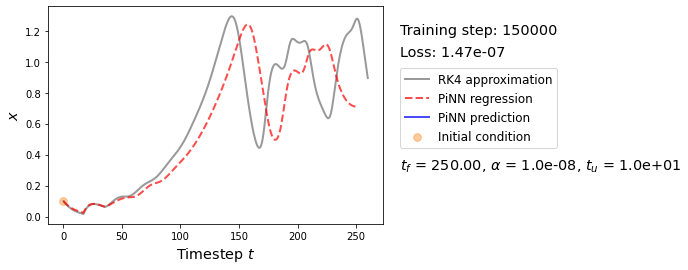

epoch = 155000  epoch loss = 0.00000014  time: 0:25:51.630360



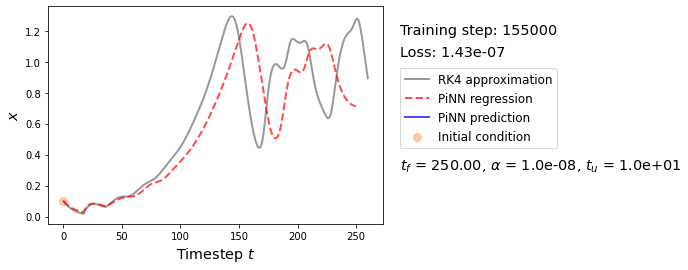

epoch = 160000  epoch loss = 0.00000097  time: 0:26:37.504593



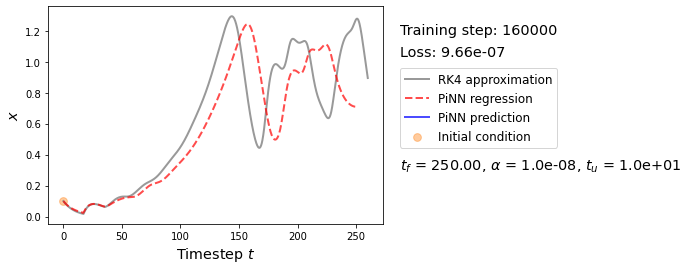

epoch = 165000  epoch loss = 0.00000396  time: 0:27:22.708817



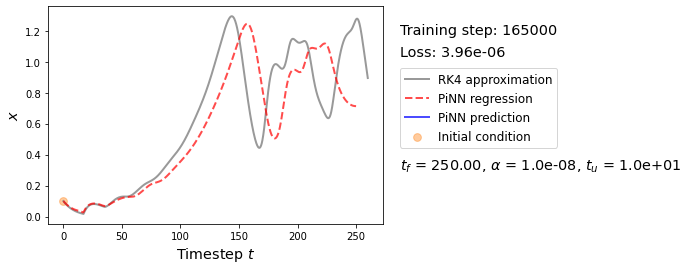

epoch = 170000  epoch loss = 0.00000007  time: 0:28:10.412637



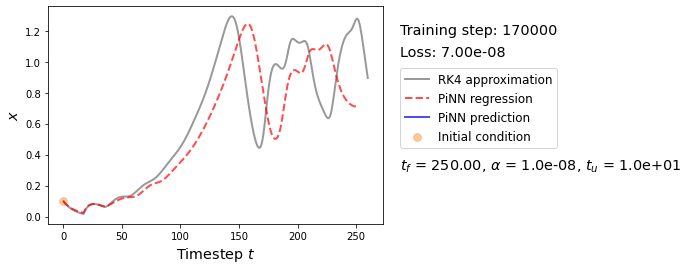

epoch = 175000  epoch loss = 0.00000717  time: 0:28:59.653939



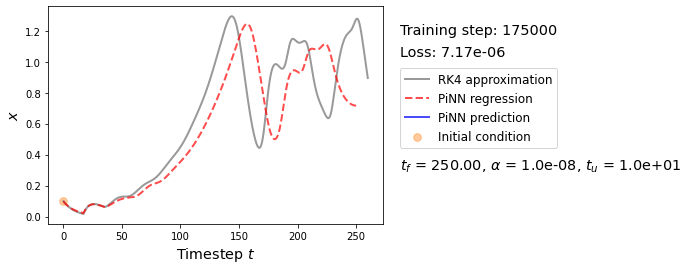

epoch = 180000  epoch loss = 0.00000568  time: 0:29:46.292725



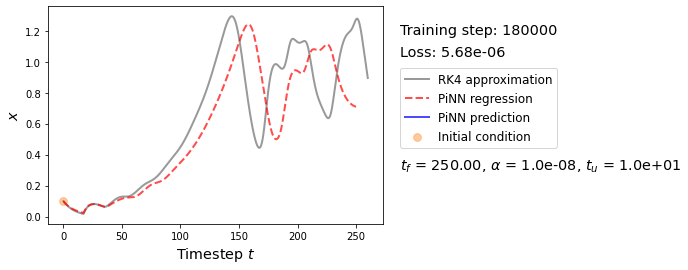

epoch = 185000  epoch loss = 0.00000810  time: 0:30:33.055000



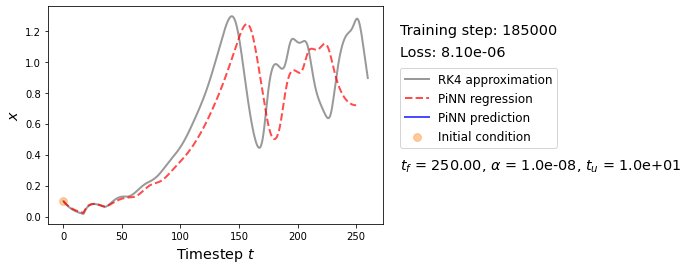

epoch = 190000  epoch loss = 0.00000017  time: 0:31:18.724722



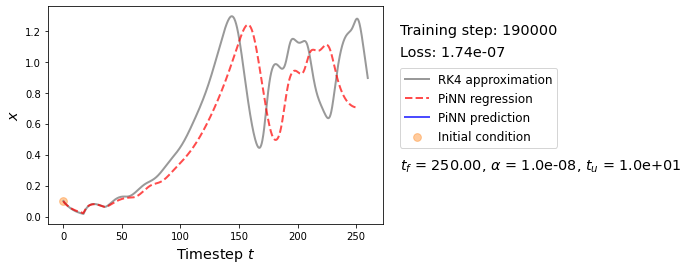

epoch = 195000  epoch loss = 0.00000075  time: 0:32:04.198750



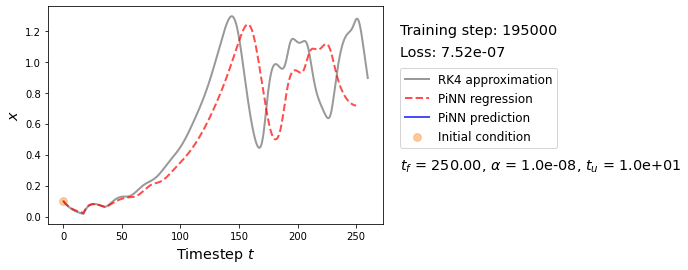

epoch = 200000  epoch loss = 0.00000370  time: 0:32:49.478438



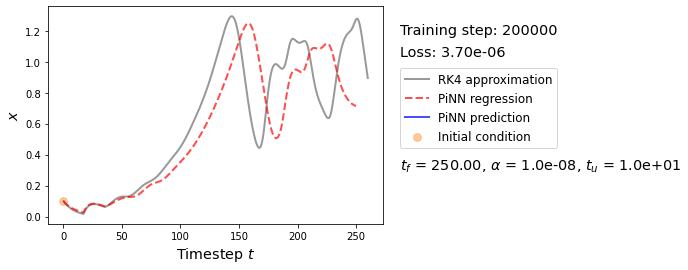

epoch = 205000  epoch loss = 0.00000251  time: 0:33:35.055486



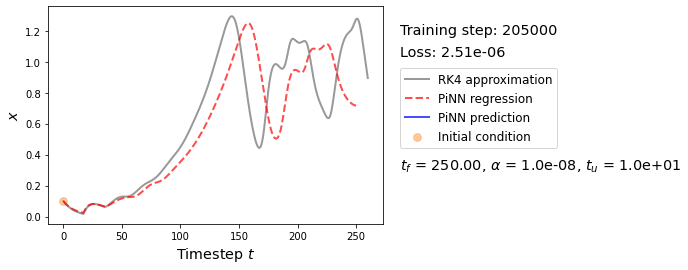

epoch = 210000  epoch loss = 0.00000387  time: 0:34:20.690149



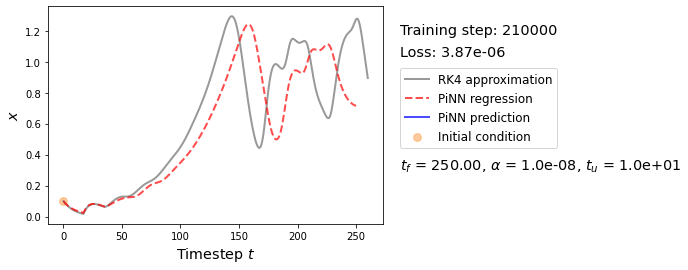

epoch = 215000  epoch loss = 0.00000399  time: 0:35:07.990684



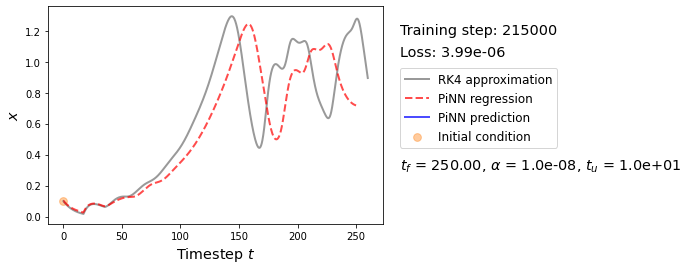

epoch = 220000  epoch loss = 0.00000607  time: 0:35:54.666928



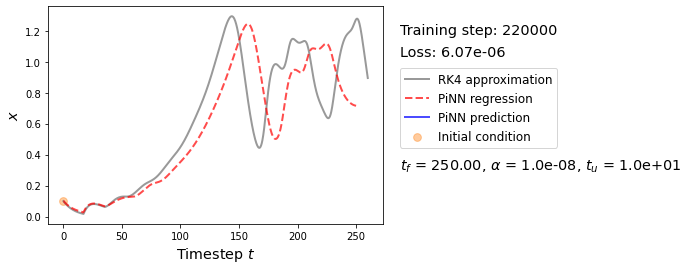

epoch = 225000  epoch loss = 0.00000387  time: 0:36:39.925532



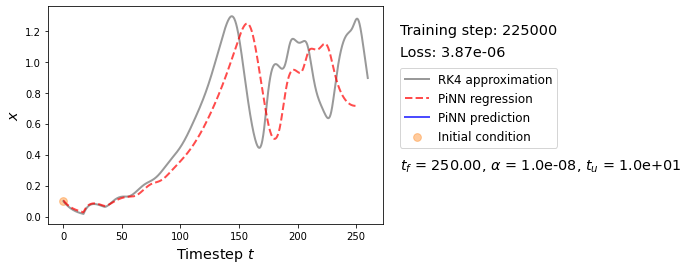

epoch = 230000  epoch loss = 0.00000112  time: 0:37:27.143099



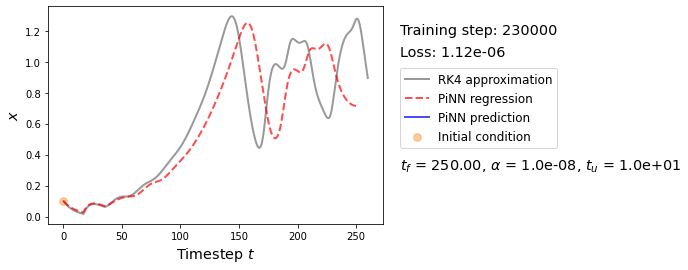

epoch = 235000  epoch loss = 0.00000332  time: 0:38:14.343619



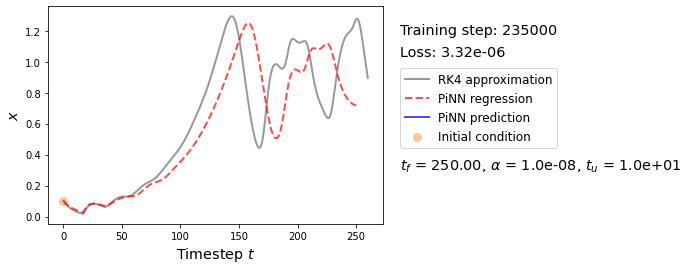

epoch = 240000  epoch loss = 0.00000095  time: 0:39:03.482752



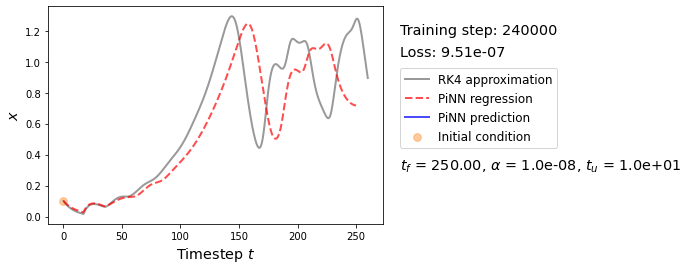

epoch = 245000  epoch loss = 0.00000039  time: 0:39:53.249436



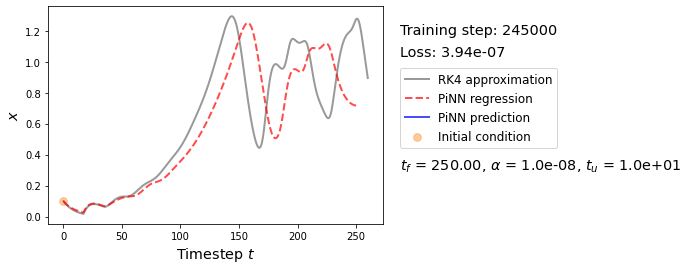

epoch = 250000  epoch loss = 0.00000387  time: 0:40:42.847531



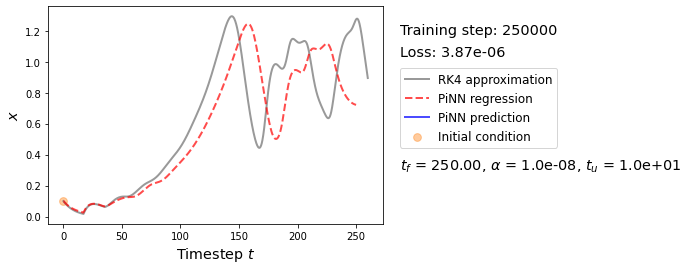

In [ ]:
# Expected runtime for tf=3.0, predict up to tf=3.5: epoch = 632000  epoch loss = 0.27340391  time: 3:00:56.512362
# Expected runtime: 1:07:21.151819
!mkdir PiNN_plots_x
torch.manual_seed(12345)
np.random.seed(12345)
time = datetime.now()

class PINN(nn.Module):
  def __init__(self, t, layers, activation_fun=nn.Tanh):
    super(PINN, self).__init__()

    self.act_fun = activation_fun()

    self.hidden_layers = [nn.Linear(u_layers[0], u_layers[1])]
    for idx, width in enumerate(u_layers[1:-1]):
      if idx < (len(u_layers[1:-1]) - 1):
        self.hidden_layers.append(nn.Linear(width, u_layers[idx + 2]))

    self.output_layer = nn.Linear(u_layers[-2], u_layers[-1]) 
    self.fnn = self.layers()
    
  def forward(self, t):
      output = self.fnn(t)
      return output

  def layers(self):
      modules = []
      for idx, layer in enumerate(self.hidden_layers):
          modules.append(layer)
          modules.append(self.act_fun)
      modules.append(self.output_layer)
      return nn.Sequential(*modules)

def plotting(pinn):
    t = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)
    x_pred = pinn.forward(t)
    x_pred = x_pred.detach().numpy()
    x = RungeKutta(MG, x0, float('%.2g'%(tf+5)), n)
    index = int(regression_index/tf) #till what index is regressed on or from what is predicted
    #Plot 2D
    t_plot2 = t_physics.detach().numpy()
    t_plot1 = np.linspace(0,float('%.2g'%(tf+5)),n)
    plt.figure()
    plt.plot(t_plot1,x, color="grey", linewidth=2, alpha=0.8, label="RK4 approximation")
    plt.plot(t_plot2[:index],x_pred[:index], 'r--', linewidth=2, alpha=0.7, label="PiNN regression")
    plt.plot(t_plot2[index:],x_pred[index:], 'b', linewidth=2, alpha=0.7, label="PiNN prediction")
    plt.scatter(t_plot1[0],x0, s=60, color="tab:orange", alpha=0.4, label='Initial condition')
    l = plt.legend(loc=(1.05,0.35), frameon=True, fontsize="large")
    plt.annotate("Training step: %i"%(e),xy=(1.05, 0.87),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("Loss: {:.2e}".format(loss),xy=(1.05, 0.77),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.annotate("$t_f$ = {:.2f}, $\\alpha$ = {:.1e}, $t_u$ = {:.1e}".format(tf, alpha, update_t),xy=(1.05, 0.25),xycoords='axes fraction',fontsize="x-large",color="k")
    plt.ylabel('$x$', fontsize="x-large")
    plt.xlabel('Timestep $t$', fontsize="x-large")
    file = "PiNN_plots_x/pinn_%.6i.png"%(e)
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    PiNN_x_files.append(file)
    plt.show()

# Used to create a iteratively gif-animation of the convergence ---------------
def save_gif(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

# (Hyper)parameters of the training -------------------------------------------
lr = 0.001                       #Learning rate
u_layers = [1, 50,50,50,50, 1]   #Layers of the PiNN
tf_org = 250                       #Original training time set
tf = 250                           #Starting final time (without update)
alpha = 0.00000001
update_t = 10
n = 1000                         #Amount of steps
regression_index = tf_org*n      #As help to see until which index the test time set was
intermediate = 5000              #Intermediate plots for the animations

# Some empty lists and starting conditions ------------------------------------
pinn_loss_hist = []
tf_list = []
iterations = []
PiNN_files = []
PiNN_x_files = []
e = 0 #Starting iteration because a while loop is used

tf_help = torch.linspace(0,100,n).view(-1,1).requires_grad_(True) #This list is just for initization of the TEM
t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True) #Time-list used in dynamic loss2 training

pinn = PINN(t_physics, u_layers)
PiNN_optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 

N_pred_x = model_ode.forward(t_physics)
N_pred_x = N_pred_x.view(-1,1)

while tf < 275: #Loop over the iterations (and stop when tf = 270 is reached and empirically converged)
    PiNN_optimizer.zero_grad()

    t_physics = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)

    if t_physics[-1] != tf_help[-1]: #to speed up the training instead of having to calculate all gradients again
        pinn = PINN(t_physics, u_layers)
        PiNN_optimizer = torch.optim.Adam(pinn.parameters(),lr=lr) 
        N_pred_x = model_ode.forward(t_physics)
        N_pred_x = N_pred_x.view(-1,1)

    #Calculation of loss1 that depends on the initial condition at t=0:
    m = pinn.forward(torch.FloatTensor([0]))
    xh = m[0]
    loss1 = torch.mean((xh-x0)**2)

    #Calculation of loss2 that depends on the dynamics of the system:
    px = pinn.forward(t_physics)
    px = px.view(-1,1)
    dxdt = torch.autograd.grad(px, t_physics, torch.ones_like(px), create_graph=True)[0] #Calculate derivatives of output of PiNN w.r.t. t_physics
    physics_x = N_pred_x - dxdt #Calculate f-residuals for the x,y,z differential equations
    loss2 = torch.mean(physics_x**2) #Total loss2 is the MSE of above residuals

    loss = 10*loss1 + loss2 #Total loss with scaling factor of 10 for loss1 due to higher importance of initial condition w.r.t. the dynamic loss
    loss.backward(retain_graph=True)
    loss = loss.detach() #Otherwise the RAM blows up due to the retain_graph=True
    PiNN_optimizer.step()
    
    e += 1        #To keep track of the iterations
    iterations.append(e)
    pinn_loss_hist.append(loss) #Saving all loss values, for the plot in the next cell

    tf_help = torch.linspace(0,tf,n).view(-1,1).requires_grad_(True)

    # Time extension method (TEM)
    if loss < alpha: #When dynamic loss2 is below threshold of alpha, add update_t to current tf
        tf_list.append(tf + update_t)
    if len(tf_list) > 0: #For updating the final time in the system
        tf = tf_list[-1]
        h = tf/n
        
    if (iterations[-1])%intermediate == 0: #Plotting/printing intermediate results using the iterations list
        print("epoch = %6d" % e, end="")
        print("  epoch loss = %10.8f" % loss, end="")
        print("  time: {}".format(datetime.now() - time), end="")
        print("\n")
        plotting(pinn)

#Creating gif-animations:
save_gif("pinn_x_prediction.gif", PiNN_x_files, fps=20, loop=0)
#Saving the model:
torch.save(pinn.state_dict(), 'PiNN_model_weights.pth')

In [ ]:
plt.plot(np.array(np.log(pinn_loss_hist)), 'r', linewidth=0.5)
plt.xlabel('Iterations', fontsize='x-large')
plt.ylabel('$log(MSE)$', fontsize='x-large')
plt.xlim(0,iterations[-1])
plt.savefig('loss_history_pinn.png')
plt.show()